In [1]:
import numpy as np
from neuralStellar2_1 import NNmodel,Teff2colour
import pymc3 as pm
import theano.tensor as T
import pandas as pd
import matplotlib.pyplot as plt
from astropy import constants
import corner
import seaborn as sns
from scipy import optimize

In [2]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu','star_feh'],Teff_scaling=5000)
m1.loadModel('Ran_files/b7/b7_best_model.h5', summary=False)
m1.getWeights()

t1=Teff2colour(['log_Teff','logg','[Fe/H]','Av'],['Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW','2MASS_Ks'])
t1.loadModel('Ran_files/atmos2BC_withK10/atmos2BC_withK10.h5', summary=False)
t1.getWeights()

M67 = pd.read_csv('data_collection/NGC_2682/NGC_2682_post_dwarfs_binaries+apogee+DSouto_reduced.csv')
#M67 = M67.sample(n=100)
N = len(M67.index)

'''
DSouto_spectra = pd.read_csv('data_collection/NGC_2682/DSouto_spectra_surfaceFeH_table.csv')
tm_ID_list = []
for i in list(DSouto_spectra['2Mass ID']):
    tm_ID_list.append(i[2:])
DSouto_spectra['tm_ID'] = tm_ID_list
matched = pd.merge(M67,DSouto_spectra[['tm_ID','[Fe/H]','[Fe/H]_err','Type']], on='tm_ID', how='left')
#mean_obs_surface_feh = np.mean(matched['[Fe/H]'])
#matched.loc[pd.isna(matched['[Fe/H]'])==True,'[Fe/H]'] = mean_obs_surface_feh
#matched.loc[pd.isna(matched['[Fe/H]_err'])==True,'[Fe/H]_err'] = 1.0
M67 = matched
'''

#[Av, dist_mod] = [0.160758, 9.660732908839677]
#[Av, dist_mod] = [0.160758, 9.726]
#[Av, dist_mod] = [0, 9.660732908839677]
[Av, dist_mod] = [0.11, 9.726]
M67_parallax = [1.1325,0.0011] #in milli arc seconds, from https://arxiv.org/pdf/1804.09378.pdf
M67_zero_point = [-82, 33] #in micro arc seconds, from https://ui.adsabs.harvard.edu/abs/2018ApJ...862...61S/abstract
Mbol = 4.75
Teff_sun = 5776.02970722

M67

ID      g_mag  g_mag_err     rp_mag  rp_mag_err  \
0    598678141384872704  14.216938   0.000205  13.729351    0.000820   
1    598687865190906496  14.027311   0.000206  13.553535    0.000882   
2    598689926775182208  15.439061   0.000354  14.820631    0.001491   
3    598691885280238464  15.112228   0.000339  14.540344    0.001374   
4    598692675554477056  14.430771   0.000244  13.921687    0.001253   
..                  ...        ...        ...        ...         ...   
344  607998907612059264  15.285105   0.000365  14.690972    0.001496   
345  608002408009810176  14.124716   0.000230  13.638537    0.000913   
346  608021516319899648  14.939761   0.000298  14.393856    0.002115   
347  608024333818424448  14.062884   0.000207  13.574839    0.001234   
348  608027151316994048  14.457603   0.000237  13.950119    0.000912   

        bp_mag  bp_mag_err  parallax  parallax_err     A_G  ...  Bp_Rp_err  \
0    14.546235    0.001284  1.087622      0.030054  0.1490  ...   0.001524   
1    14.345044    0.001484  1.131886      0.030607  0.2170  ...   0.001726   
2    15.905857    0.002502  1.138978      0.046568  0.1602  ...   0.002913   
3    15.531276    0.002783  1.127895      0.043980  0.0897  ...   0.003103   
4    14.783209    0.001728  1.142115      0.033718  0.1277  ...   0.002134   
..         ...         ...       ...           ...     ...  ...        ...   
344  15.729301    0.002109  1.107453      0.046225  0.1150  ...   0.002586   
345  14.455574    0.001086  1.095042      0.029196  0.2510  ...   0.001419   
346  15.330288    0.002693  1.111215      0.039544  0.0257  ...   0.003424   
347  14.394543    0.001133  1.121068      0.031305  0.2790  ...   0.001676   
348  14.809588    0.001315  1.115062      0.040701  0.1325  ...   0.001600   

        value  DSouto_feh  DSouto_feh_err APOGEE_feh  APOGEE_feh_err  \
0   -3.153638         NaN             NaN        NaN             NaN   
1   -3.059169         NaN             NaN        NaN             NaN   
2   -3.369478         NaN             NaN        NaN             NaN   
3   -3.396251         NaN             NaN        NaN             NaN   
4   -3.200080         NaN             NaN        NaN             NaN   
..        ...         ...             ...        ...             ...   
344 -3.391390         NaN             NaN        NaN             NaN   
345 -3.060844         NaN             NaN        NaN             NaN   
346 -3.428157         NaN             NaN        NaN             NaN   
347 -2.989010         NaN             NaN        NaN             NaN   
348 -3.234608         NaN             NaN        NaN             NaN   

     TELESCOPE  FIELD  SNR  ASPCAPFLAGS  
0          NaN    NaN  NaN          NaN  
1          NaN    NaN  NaN          NaN  
2          NaN    NaN  NaN          NaN  
3          NaN    NaN  NaN          NaN  
4          NaN    NaN  NaN          NaN  
..         ...    ...  ...          ...  
344        NaN    NaN  NaN          NaN  
345        NaN    NaN  NaN          NaN  
346        NaN    NaN  NaN          NaN  
347        NaN    NaN  NaN          NaN  
348        NaN    NaN  NaN          NaN  

[349 rows x 31 columns]

In [3]:
def gen_cluster(mass, age, feh, Y, MLT, Av, dist_mod):
    obs = m1.predict([mass,age,feh,Y,MLT])
    
    Teff = 10**obs[1]
    L = 10**obs[0]
    radius_sq = L/((Teff/Teff_sun)**4)
    logg = np.log10(100*constants.G.value*(mass/radius_sq)*(constants.M_sun.value/constants.R_sun.value**2))
    s_feh = obs[3]
    
    BCs = t1.model.predict(np.array([np.log10(Teff),logg,s_feh,Av]).T).T
    
    BCg = BCs[0]
    BCbp = BCs[2]
    BCrp = BCs[3]
    BCk = BCs[4]
    
    mG = -2.5*np.log10(L)+Mbol-BCg+dist_mod
    mK = -2.5*np.log10(L)+Mbol-BCk+dist_mod
    Bp_Rp = BCrp - BCbp
    
    return mG,mK,Bp_Rp

def interpolate(modelx, modely, targetx):
    arg_sort = np.argsort(modelx)
    modelx = modelx[arg_sort]
    modely = modely[arg_sort]
    targety = []
    for i in targetx:
        if i<modelx[0]:
            slope = (modely[1]-modely[0])/(modelx[1]-modelx[0])
            targety.append(modely[0]+slope*(i-modelx[0]))
        elif i>modelx[-1]:
            slope = (modely[-1]-modely[-2])/(modelx[-1]-modelx[-2])
            targety.append(modely[-1]+slope*(i-modelx[-1]))
        else:
            for j,modelx_j in enumerate(modelx):
                if i>modelx_j and i<modelx[j+1]:
                    slope = (modely[j+1]-modely[j])/(modelx[j+1]-modelx_j)
                    targety.append(modely[j]+slope*(i-modelx_j))
                    break
    return targety

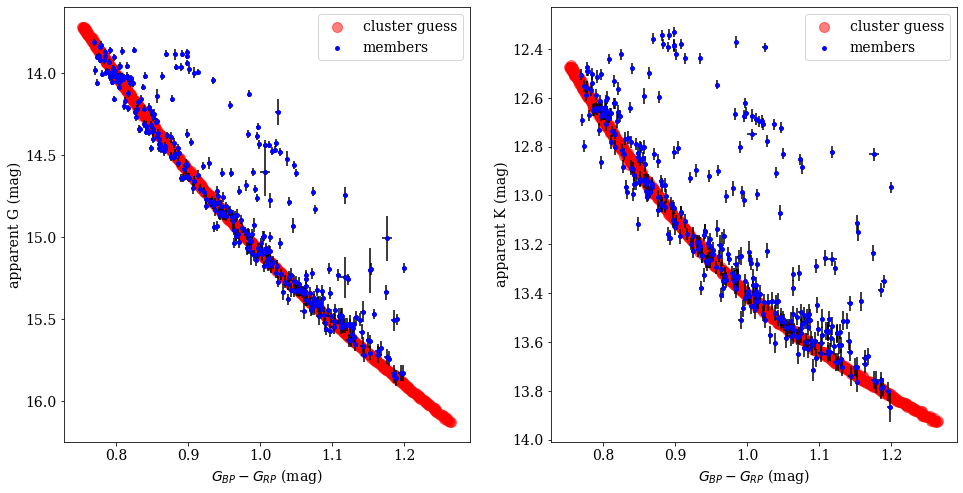

0.009991143889697796 0.025691430849891006 -0.01570028696019321


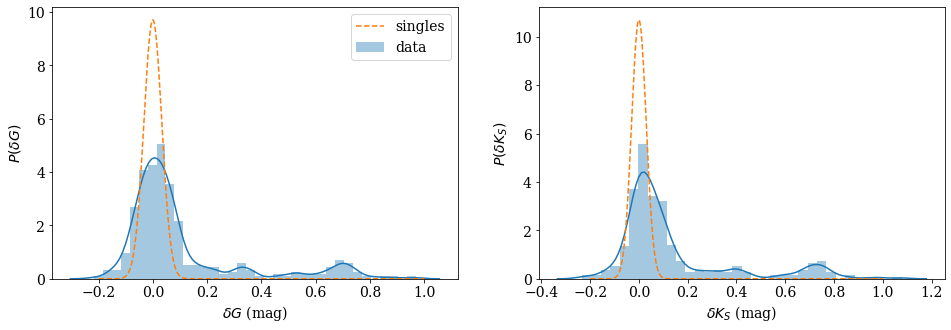

In [4]:
TN = 1000
Tmass = np.linspace(0.8,1.20,TN)
Tage = np.ones(TN)*1.749
Tfeh = np.ones(TN)*-0.019
TY = np.ones(TN)*0.248
mean_MLT = 1.799
MLT_f = 0.833
TMLT = MLT_f*(Tmass-1.0)+mean_MLT+np.random.randn(TN)*0.015
Av = 0.191
TAv = np.ones(TN)*Av
#TAv = np.random.randn(TN)*0.056+Av
dist_mod = 9.728

TmG, TmK, TBp_Rp = gen_cluster(Tmass, Tage, Tfeh, TY, TMLT, TAv, dist_mod)

fig, ax=plt.subplots(1,2, figsize=(16,8))
ax[0].scatter(TBp_Rp, TmG, s=100, zorder=1, c='red', label='cluster guess', alpha=0.5)
ax[0].errorbar(M67['Bp_Rp'], M67['g_mag'], xerr=M67['Bp_Rp_err'], yerr=M67['g_mag_err']*100, fmt='.', zorder=2, c='black')
ax[0].scatter(M67['Bp_Rp'], M67['g_mag'], s=15, zorder=3, c='blue', label='members')
ax[0].set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
ax[0].set_ylabel('apparent G (mag)')
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].legend()

ax[1].scatter(TBp_Rp, TmK, s=100, zorder=1, c='red', label='cluster guess', alpha=0.5)
ax[1].errorbar(M67['Bp_Rp'], M67['K_mag'], xerr=M67['Bp_Rp_err'], yerr=M67['K_mag_err'], fmt='.', zorder=2, c='black')
ax[1].scatter(M67['Bp_Rp'], M67['K_mag'], s=15, zorder=3, c='blue', label='members')
ax[1].set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
ax[1].set_ylabel('apparent K (mag)')
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].legend()
plt.show()

fig, ax = plt.subplots(1,2, figsize=[16,5])
TMLT = MLT_f*(Tmass-1.0)+mean_MLT
TAv = np.ones(TN)*Av
TmG, TmK, TBp_Rp = gen_cluster(Tmass, Tage, Tfeh, TY, TMLT, TAv, dist_mod)
diffG = interpolate(TBp_Rp, TmG, M67['Bp_Rp']) - M67['g_mag']
diffK = interpolate(TBp_Rp, TmK, M67['Bp_Rp']) - M67['K_mag']
print(np.median(diffG[diffG<0.2]),np.median(diffK[diffK<0.2]), np.median(diffG[diffG<0.2])-np.median(diffK[diffK<0.2]))

sns.distplot(diffG, ax=ax[0], label='data')
ind = np.linspace(-0.2, 1.0, 1000)
mean_g_mag_err = np.mean(M67['g_mag_err'])*100
single = 0.8 / np.sqrt(2 * np.pi) / mean_g_mag_err * \
        np.exp(-0.5 * (ind)**2 / mean_g_mag_err**2)
ax[0].plot(ind, single, linestyle='--', label='singles')
sns.distplot(diffK, ax=ax[1], label='data')
ax[0].legend()
ax[0].set_xlabel('$\delta G$ (mag)')
ax[0].set_ylabel('$P(\delta G)$')

mean_k_mag_err = np.mean(M67['K_mag_err'])
single = 0.8 / np.sqrt(2 * np.pi) / mean_k_mag_err * \
        np.exp(-0.5 * (ind)**2 / mean_k_mag_err**2)
ax[1].plot(ind, single, linestyle='--', label='singles')
ax[1].set_xlabel('$\delta K_S$ (mag)')
ax[1].set_ylabel('$P(\delta K_S)$')
plt.show()

In [ ]:
model = pm.Model()
with model:
    
    #cluster-wide fundamentals
    Age_mu = pm.Deterministic('mean_age',pm.Beta('age_beta',2,2)*4+2)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('feh_beta',2,2)*0.3-0.15)
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('Y_beta',2,2)*0.0334+0.2466)#0.24668 \pm 0.00007 is big bang nucleosynthesis fraction from Plank mission
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('MLT_beta',10,10)*0.6+1.7)   #mean MLT is actually MLT at mass=1.0 (pivot) if slope MLT model is used
    MLT_f = pm.Normal('MLT_f', 0, 0.3)      #MLT's mass dependent slope
    MLT_sigma = pm.Lognormal('spread_MLT', T.log(0.01), 0.5)
    
    #per star fundamentals
    M = pm.Deterministic('mass', pm.Beta('mass_beta',1.1,1.1,shape=N)*(1.2-0.8)+0.8)
    Age = T.ones(N)*Age_mu
    feh = T.ones(N)*feh_mu
    Y = T.ones(N)*Y_mu
    #MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)        #max pool with uniform MLT value for all stars
    #MLT = pm.Deterministic('MLT', MLT_mu+MLT_f*(M-1.0))   #max pool with deterministic slope on mass
    MLT = pm.Bound(pm.Normal, lower=1.5, upper=2.5)('MLT', MLT_mu + MLT_f*(M-1.0), sigma=MLT_sigma, shape=N)
    
    #NN calculation
    obs = m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT]))
    
    #intermediate observables
    radius = pm.Deterministic('radius', 10**obs[0])
    Teff = pm.Deterministic('Teff', (10**obs[1])*5000)
    L = pm.Deterministic('L', (radius**2)*((Teff/Teff_sun)**4))
    logg = pm.Deterministic('logg', T.log10(100*constants.G.value*(M/radius**2)*(constants.M_sun.value/constants.R_sun.value**2)))
    true_s_feh = pm.Deterministic('true_s_feh', obs[3])
    cond = M67['APOGEE_feh'].notna()  # boolean mask data where it is not NaN
    obs_s_feh = pm.Normal('obs_s_feh', true_s_feh[T.nonzero(cond)], M67[cond]['APOGEE_feh_err']*5, observed=M67[cond]['APOGEE_feh'])

    #extinction prior
    A_V_mu = pm.Deterministic('mean_A_V', pm.Beta('Av_beta',1.1,1.1)*0.2) # X & Y are 'sensible' values
    #A_V_std = pm.Bound(pm.Lognormal, upper=0.7)('spread_A_V', T.log(0.01), 1.0) # Different X & Y but still sensible
    A_V_std = pm.Deterministic('spread_A_V', pm.Beta('Av_std_beta',1.1,5.0)*0.07)   #lognormal prior on spread Av is not stable, having to resort to a beta function
    A_V = pm.TruncatedNormal('A_V', mu=A_V_mu, sigma=A_V_std, lower=0, shape=N)
    
    #second NN calculation
    BCs = t1.manualPredict(T.as_tensor_variable([T.log10(Teff), logg, true_s_feh, A_V]))
    
    #BCs
    BCg = BCs[0,:]
    BCbp = BCs[2,:]
    BCrp = BCs[3,:]
    BCk = BCs[4,:]
    
    #distance and parallax
    dist_mod_ = pm.Normal('dist_mod', dist_mod, 1.0, testval=dist_mod)
    true_parallax = pm.Deterministic('true_parallax', 10**(-dist_mod_/5-1)*1000)
    #obs_adj_parallax = pm.Normal('obs_adj_parallax', true_parallax, np.sqrt(M67_parallax[1]**2+(M67_zero_point[1]/1000)**2), 
    #                         observed=M67_parallax[0]-M67_zero_point[0]/1000)
    obs_adj_parallax = pm.Normal('obs_adj_parallax', true_parallax, M67_parallax[1], observed=M67_parallax[0])
    
    #true observables
    true_mG = pm.Deterministic('true_mG', -2.5*T.log10(L)+Mbol-BCg+dist_mod_)
    true_mK = pm.Deterministic('true_mK', -2.5*T.log10(L)+Mbol-BCk+dist_mod_)
    true_Bp_Rp = pm.Deterministic('true_Bp_Rp', BCrp - BCbp)
    
    #dealing with multiples
    #q = pm.Deterministic('q', pm.Beta('q_beta', 1.1,1.1, testval=0.6)*0.5+0.5)
    q = pm.Beta('q', 1.1,1.1, testval=0.8)
    delta_mG = pm.Lognormal('delta_mG', T.log(0.3), 0.4)
    sigma_multiple_G = pm.Lognormal('sigma_multiple_G', T.log(0.3), 0.3)
    dist_singular_G = pm.Normal.dist(0, np.mean(M67['g_mag_err'])*100)   #assuming a multiple of 100 for now. Also not best to use mean of errors but can't find a way to set individual sigmas for each star
    dist_multiple_G = pm.Normal.dist(-delta_mG, sigma_multiple_G)
    
    delta_mK = pm.Lognormal('delta_mK', T.log(0.3), 0.4)
    sigma_multiple_K = pm.Lognormal('sigma_multiple_K', T.log(0.3), 0.3)
    dist_singular_K = pm.Normal.dist(0, np.mean(M67['K_mag_err']))
    dist_multiple_K = pm.Normal.dist(-delta_mK, sigma_multiple_K)
    
    #obs observables
    obs_mG = pm.Mixture('obs_mG', w=[q, 1-q], comp_dists = [dist_singular_G, dist_multiple_G], \
                    observed=M67['g_mag'].values - true_mG)
    obs_mK = pm.Mixture('obs_mK', w=[q, 1-q], comp_dists = [dist_singular_K, dist_multiple_K], \
                    observed=M67['K_mag'].values - true_mK)
    obs_Bp_Rp = pm.Normal('obs_Bp_Rp', mu=true_Bp_Rp, sigma=M67['Bp_Rp_err'], observed=M67['Bp_Rp'])

In [6]:
trace_file = 'pymc3_traces/M67_c30'
trace= pm.load_trace(directory=trace_file, model=model)

In [21]:
with model:
    trace = pm.sample(500,tune=50, init='adapt_diag', target_accept=0.999, cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mK_shift, sigma_multiple_K, sigma_single_K, delta_mK, mG_shift, sigma_multiple_G, sigma_single_G, delta_mG, q, dist_mod_norm, A_V_, spread_A_V, Av_beta, mass_beta, MLT_beta, Y_beta, feh_beta, age_beta]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████████| 550/550 [11:27<00:00,  1.25s/it]
The acceptance probability does not match the target. It is 0.9922400568482187, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9849138394832309, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 

In [8]:
summary = pm.summary(trace, var_names=['mean_age','mean_feh','mean_Y','mean_MLT','MLT_f','spread_MLT',
                                       'dist_mod','mean_A_V','spread_A_V','q',
                                       'delta_mG','sigma_multiple_G',
                                       'delta_mK','sigma_multiple_K'
                                      ])
summary.to_csv(trace_file+'/summary.csv')
summary

C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mean_age          1.749  0.199   1.390    2.153      0.050    0.037      16.0   
mean_feh         -0.019  0.006  -0.031   -0.008      0.001    0.000     114.0   
mean_Y            0.248  0.001   0.247    0.250      0.000    0.000     572.0   
mean_MLT          1.799  0.017   1.766    1.836      0.007    0.005       6.0   
MLT_f             0.833  0.135   0.588    1.067      0.052    0.039       7.0   
spread_MLT        0.010  0.004   0.004    0.018      0.001    0.000      51.0   
dist_mod          9.728  0.002   9.724    9.732      0.000    0.000    1466.0   
mean_A_V          0.191  0.007   0.177    0.200      0.001    0.001      38.0   
spread_A_V        0.056  0.003   0.050    0.061      0.000    0.000     159.0   
q                 0.804  0.017   0.771    0.836      0.001    0.000     896.0   
delta_mG          0.480  0.034   0.415    0.542      0.001    0.001     667.0   
sigma_multiple_G  0.205  0.027   0.157    0.257      0.001    0.001     902.0   
delta_mK          0.463  0.038   0.390    0.535      0.001    0.001    2059.0   
sigma_multiple_K  0.258  0.024   0.209    0.301      0.001    0.000    1754.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
mean_age            15.0      17.0      52.0   1.21  
mean_feh           114.0     114.0     207.0   1.05  
mean_Y             572.0     601.0    1041.0   1.00  
mean_MLT             6.0       7.0      15.0   1.65  
MLT_f                7.0       8.0      15.0   1.48  
spread_MLT          51.0      52.0      70.0   1.08  
dist_mod          1466.0    1467.0    2871.0   1.00  
mean_A_V            38.0      58.0      55.0   1.06  
spread_A_V         159.0     159.0    1118.0   1.03  
q                  893.0     887.0    2988.0   1.01  
delta_mG           591.0     579.0    2705.0   1.02  
sigma_multiple_G   902.0     909.0    2832.0   1.01  
delta_mK          2024.0    2053.0    3865.0   1.00  
sigma_multiple_K  1754.0    1700.0    2608.0   1.00

C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


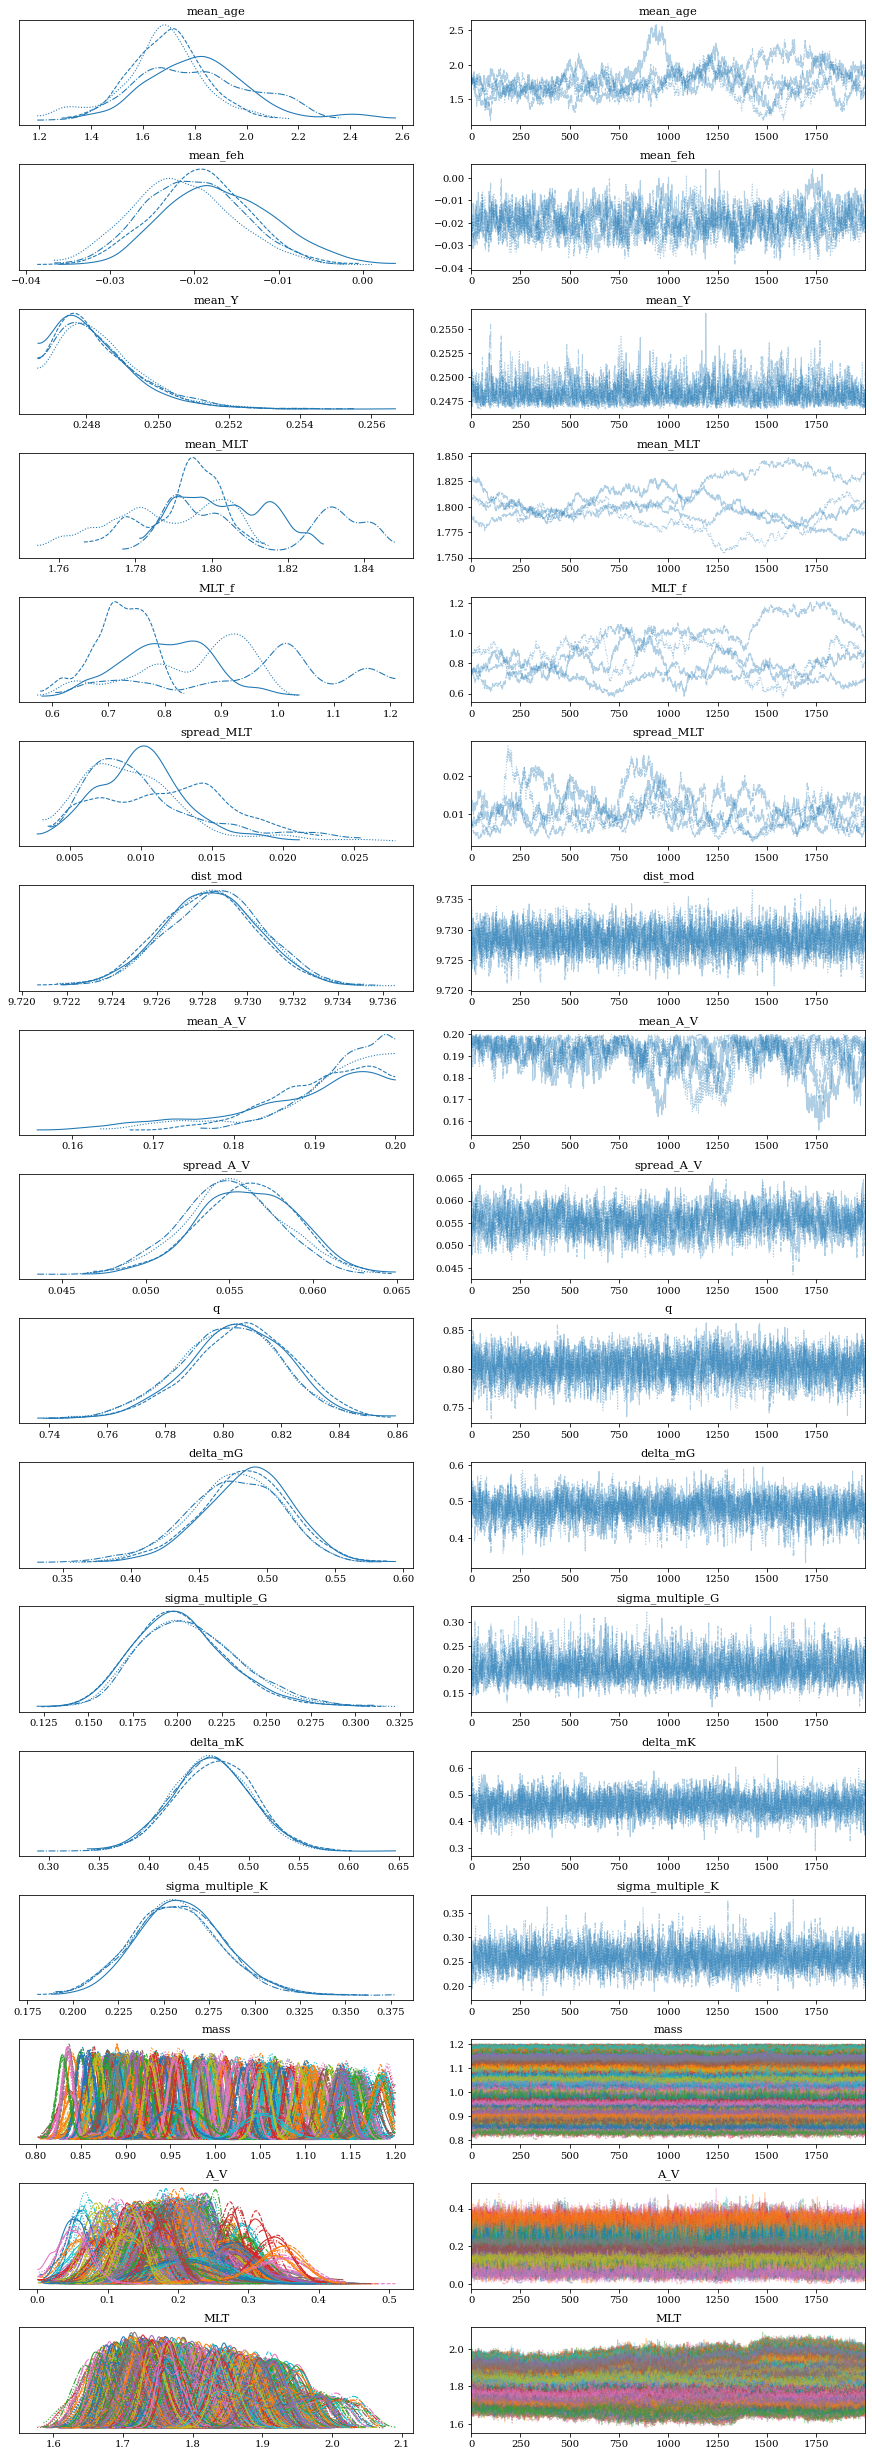

In [9]:
pm.plots.traceplot(trace,var_names=['mean_age','mean_feh','mean_Y','mean_MLT','MLT_f','spread_MLT',
                                    'dist_mod','mean_A_V','spread_A_V','q',
                                    'delta_mG','sigma_multiple_G',
                                    'delta_mK','sigma_multiple_K',
                                    'mass','A_V','MLT'
                                   ],compact=True)
plt.savefig(trace_file+'/trace_plot.png')
plt.show()

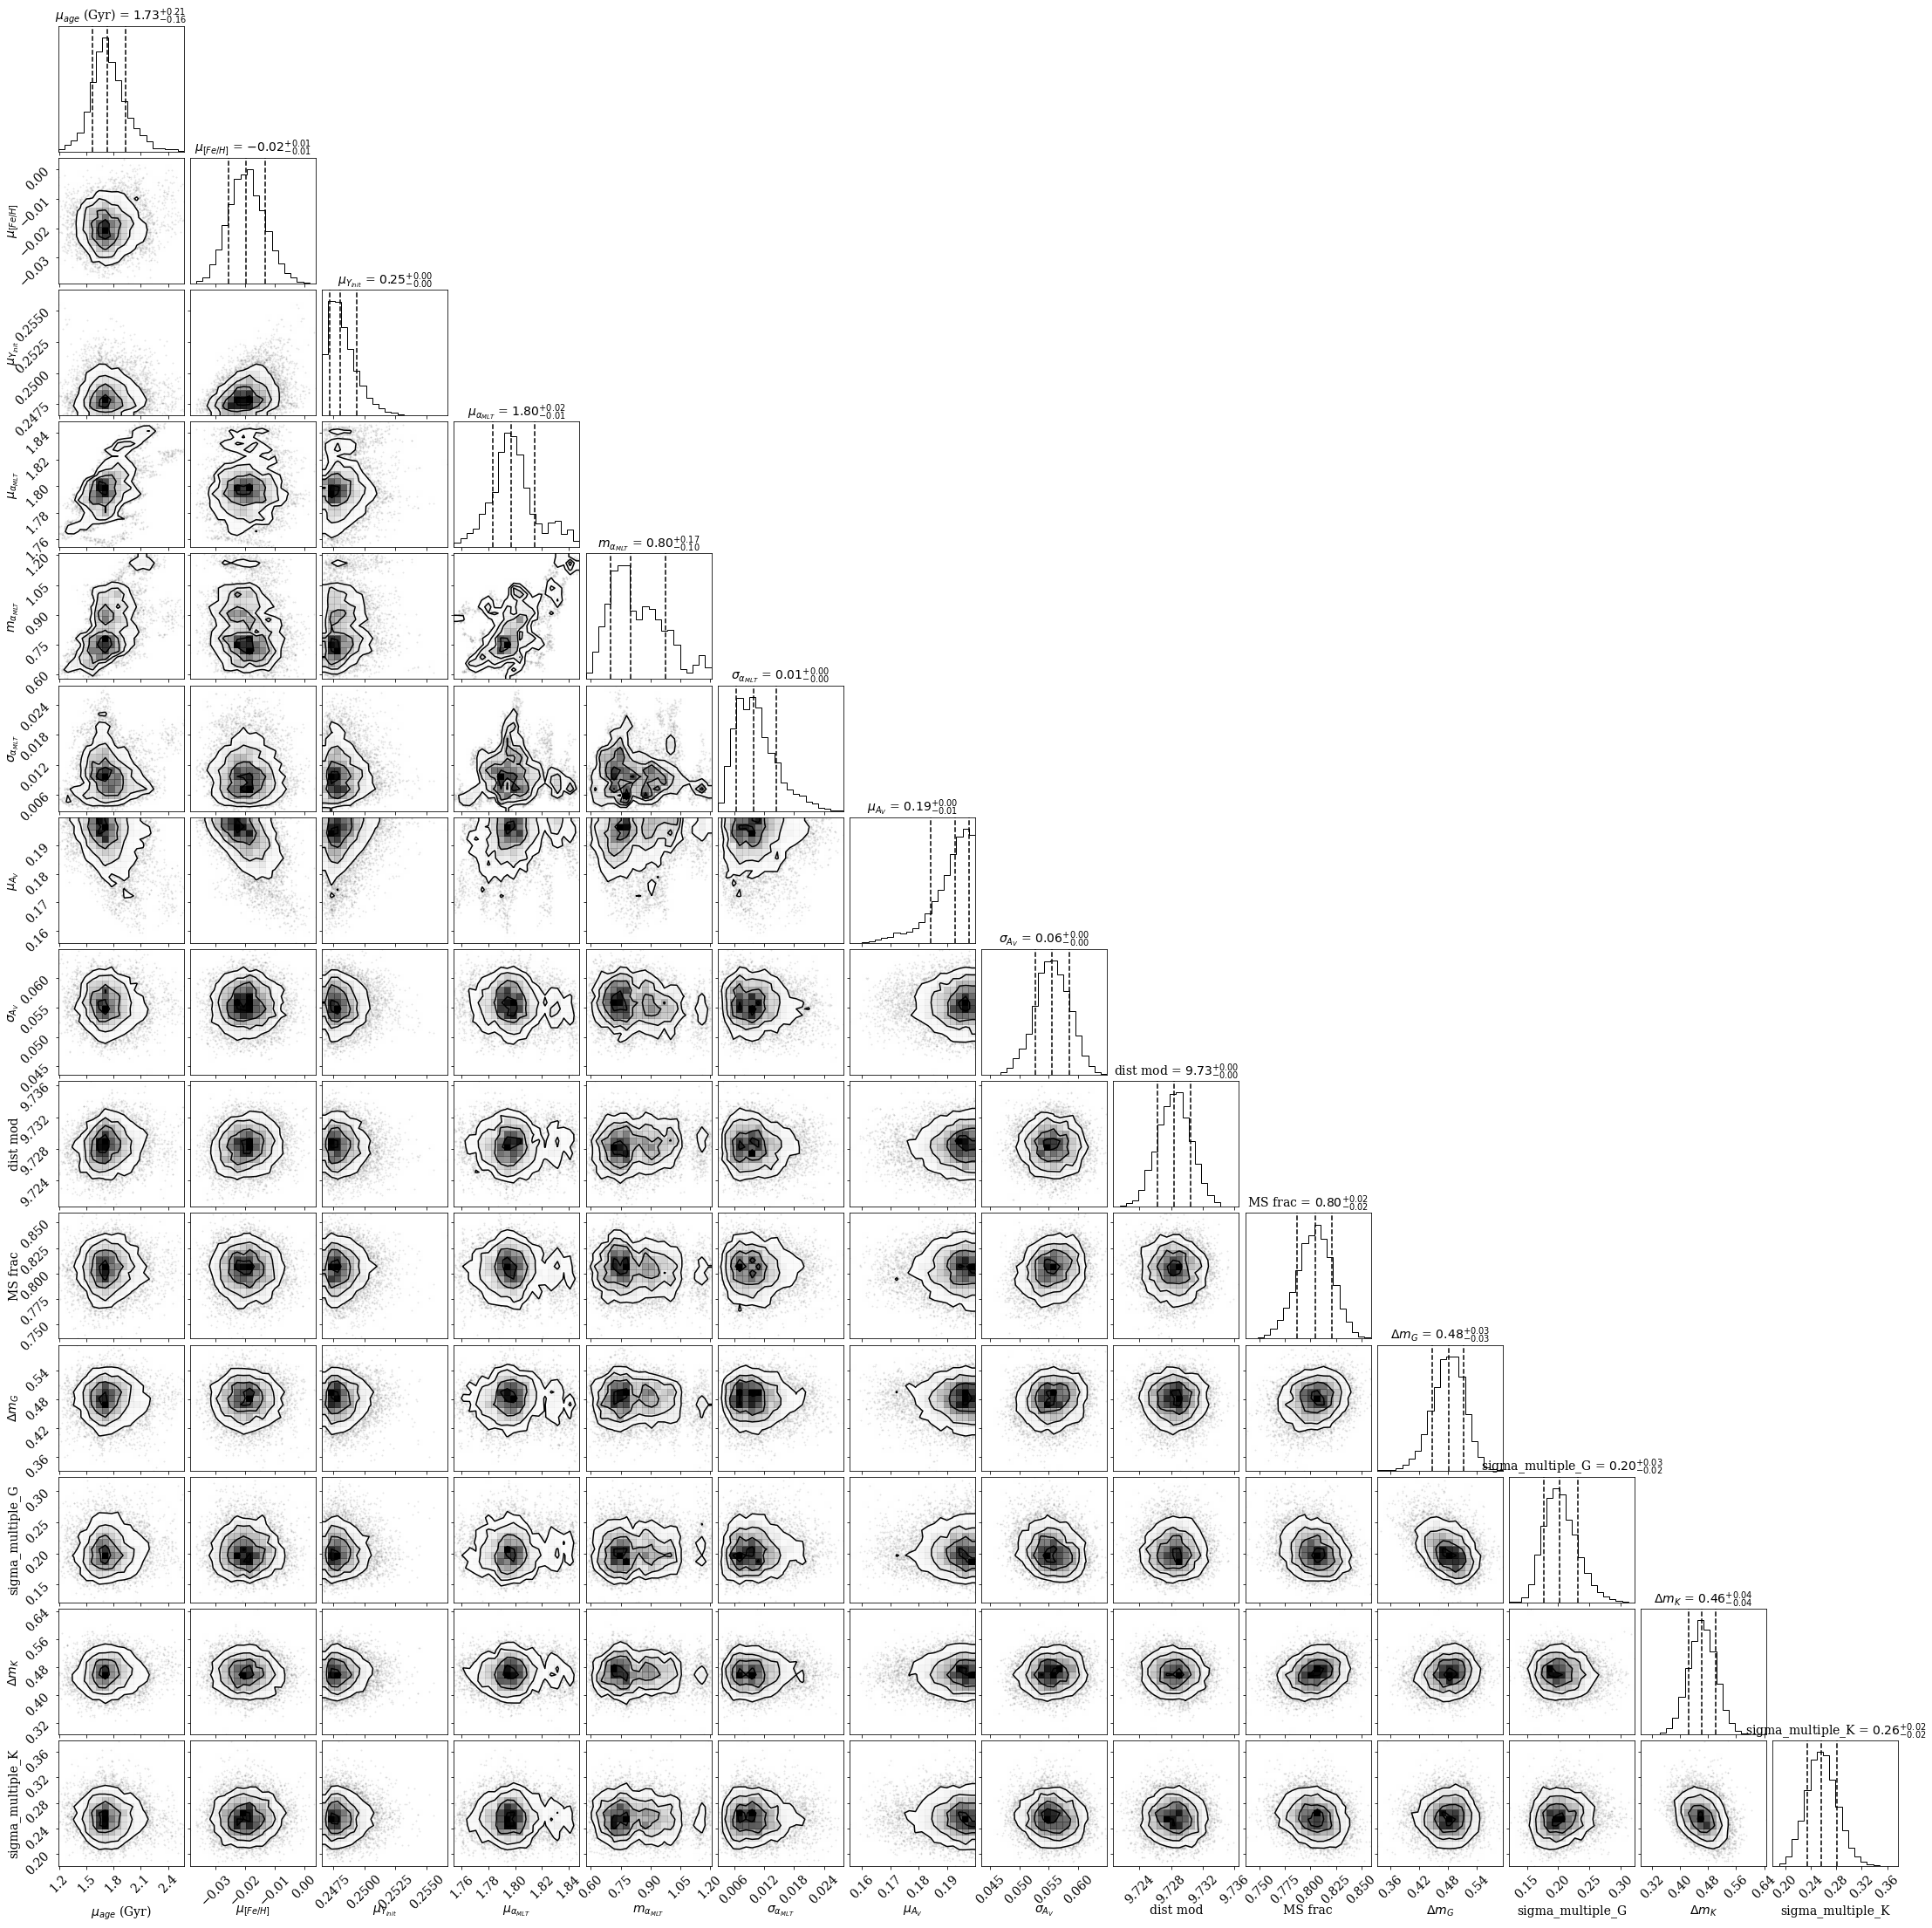

In [10]:
#corner plots
corner.corner(np.array([trace['mean_age'],trace['mean_feh'],trace['mean_Y'],trace['mean_MLT'],trace['MLT_f'],trace['spread_MLT'],
                        trace['mean_A_V'],trace['spread_A_V'],trace['dist_mod'],trace['q'],
                        trace['delta_mG'],trace['sigma_multiple_G'],
                        trace['delta_mK'],trace['sigma_multiple_K']]).T,
              labels=[r'$\mu_{age}$ (Gyr)', r'$\mu_{[Fe/H]}$', r'$\mu_{Y_{init}}$', r'$\mu_{\alpha_{MLT}}$', r'$m_{\alpha_{MLT}}$', r'$\sigma_{\alpha_{MLT}}$',
                      r'$\mu_{A_V}$', r'$\sigma_{A_V}$', 'dist mod', 'MS frac',
                      r'$\Delta m_G$', 'sigma_multiple_G',
                      r'$\Delta m_K$', 'sigma_multiple_K'],
             quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14})
plt.savefig(trace_file+'/corner.png')
plt.show()

In [11]:
def setup1(trace, cluster_df, draw, f_G=10):
    #noise model with multiplication factor f on obs mag err to account for spread in MS
    Fg_mag = trace['true_mG'][draw]
    Fk_mag = trace['true_mK'][draw]
    FBp_Rp = trace['true_Bp_Rp'][draw]
    all_g = trace['true_mG']
    all_k = trace['true_mK']
    gerr = cluster_df['g_mag_err']*trace['f_G'][draw]
    kerr = cluster_df['K_mag_err']*trace['f_K'][draw]
    return Fg_mag, Fk_mag, FBp_Rp, all_g, all_k, gerr, kerr

def setup2(trace, cluster_df, draw, f_G=10):
    #noise model where spread in MS is accounted seperately with spread 'mG_shift', obs error is added afterwards
    Fg_mag = trace['true_mG'][draw]+trace['mG_shift'][draw]
    Fk_mag = trace['true_mK'][draw]+trace['mK_shift'][draw]
    FBp_Rp = trace['true_Bp_Rp'][draw]
    all_g = trace['true_mG']+trace['mG_shift']
    all_k = trace['true_mK']+trace['mK_shift']
    gerr = cluster_df['g_mag_err']*f_G
    kerr = cluster_df['K_mag_err']
    return Fg_mag, Fk_mag, FBp_Rp, all_g, all_k, gerr, kerr

def setup3(trace, cluster_df, draw, f_G=10):
    #noise model where multiplication factor f on obs mag err is fixed, all spread is relegated to spread Av
    Fg_mag = trace['true_mG'][draw]
    Fk_mag = trace['true_mK'][draw]
    FBp_Rp = trace['true_Bp_Rp'][draw]
    all_g = trace['true_mG']
    all_k = trace['true_mK']
    gerr = cluster_df['g_mag_err']*f_G
    kerr = cluster_df['K_mag_err']
    return Fg_mag, Fk_mag, FBp_Rp, all_g, all_k, gerr, kerr

def plotSample(trace, cluster_df, title, setup_func, draw=None, f_G=10, show_gen=False, pooling_choice=None, 
               dpi=None, savename=None):
    if draw is None:
        draw = np.random.randint(0,len(trace['true_mG']))
    Fg_mag, Fk_mag, FBp_Rp, all_g, all_k, gerr, kerr = setup_func(trace, cluster_df, draw, f_G=f_G)
    
    fig, ax=plt.subplots(1,2,figsize=[14,7], dpi=dpi)
    ax[0].errorbar(cluster_df['Bp_Rp'], cluster_df['g_mag'], xerr=cluster_df['Bp_Rp_err'], yerr=gerr, fmt='.', zorder=2, c='grey')
    ax[0].scatter(cluster_df['Bp_Rp'], cluster_df['g_mag'], s=15, zorder=3, c='blue', label='cluster data')
    ax[0].scatter(FBp_Rp, Fg_mag, s=15, zorder=5, c='red', label='HBM guesses')
    ax[0].scatter(trace['true_Bp_Rp'], all_g, s=10, zorder=1, alpha=0.7, color=[0.6,0.6,0.6], label='sample regions')
    
    ax[1].errorbar(cluster_df['Bp_Rp'], cluster_df['K_mag'], xerr=cluster_df['Bp_Rp_err'], yerr=kerr, fmt='.', zorder=2, c='grey')
    ax[1].scatter(cluster_df['Bp_Rp'], cluster_df['K_mag'], s=15, zorder=3, c='blue', label='cluster data')
    ax[1].scatter(FBp_Rp, Fk_mag, s=15, zorder=5, c='red', label='HBM guesses')
    ax[1].scatter(trace['true_Bp_Rp'], all_k, s=10, zorder=1, alpha=0.7, color=[0.6,0.6,0.6], label='sample regions')
    
    if show_gen==True:
        TN = len(cluster_df.index)
        Tmass = trace['mass'][draw]
        Tage = np.ones(TN)*trace['mean_age'][draw]
        Tfeh = np.ones(TN)*trace['mean_feh'][draw]
        TY = np.ones(TN)*trace['mean_Y'][draw]
        
        if pooling_choice is None:
            raise NameError('Specify pooling_choice for generative cluster!')
        if pooling_choice == 'max':
            TMLT = np.ones(TN)*trace['mean_MLT'][draw]
        elif pooling_choice == 'partial':
            TMLT = np.random.randn(TN)*trace['spread_MLT'][draw]+trace['mean_MLT'][draw]
        elif pooling_choice == 'Mslope':
            TMLT = trace['MLT_f'][draw]*(trace['mass'][draw]-1.0)+trace['mean_MLT'][draw]
        elif pooling_choice == 'Mslope_with_spread':
            TMLT = trace['MLT_f'][draw]*(trace['mass'][draw]-1.0)+trace['mean_MLT'][draw]+np.random.randn(TN)*trace['spread_MLT'][draw]
        
        TAv = np.random.randn(TN)*trace['spread_A_V'][draw]+trace['mean_A_V'][draw]
        dist_mod = trace['dist_mod'][draw]
        
        TmG, TmK, TBp_Rp = gen_cluster(Tmass, Tage, Tfeh, TY, TMLT, TAv, dist_mod)
        binary_index = np.random.choice(TN, int(np.round(TN*(1-trace['q'][draw]),0)))
        TmG[binary_index] = TmG[binary_index]-(np.random.randn(len(binary_index))*trace['sigma_multiple_G'][draw]+trace['delta_mG'][draw])
        ax[0].scatter(TBp_Rp, TmG, s=15, zorder=4, color='limegreen', label='generative cluster')
        TmK[binary_index] = TmK[binary_index]-(np.random.randn(len(binary_index))*trace['sigma_multiple_K'][draw]+trace['delta_mK'][draw])
        ax[1].scatter(TBp_Rp, TmK, s=15, zorder=4, color='limegreen', label='generative cluster')
        
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
    ax[0].set_ylabel('apparent G (mag)')
    ax[0].legend()
    ax[1].set_ylim(ax[1].get_ylim()[::-1])
    ax[1].set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
    ax[1].set_ylabel('apparent K (mag)')
    fig.suptitle(title)
    if savename is not None:
        plt.savefig(savename)
    plt.show()

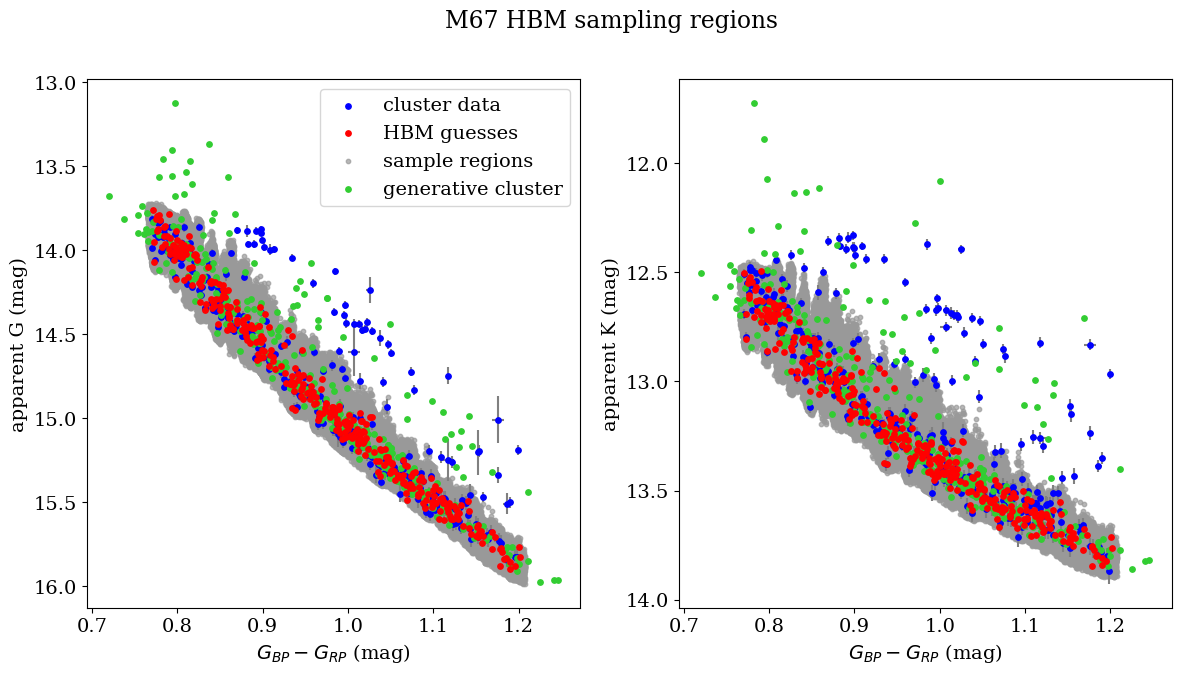

In [12]:
plotSample(trace, M67, 'M67 HBM sampling regions', setup3, draw=None, f_G=100, show_gen=True, pooling_choice='Mslope_with_spread', 
           dpi=100, savename=trace_file+'/sampling_regions.png')

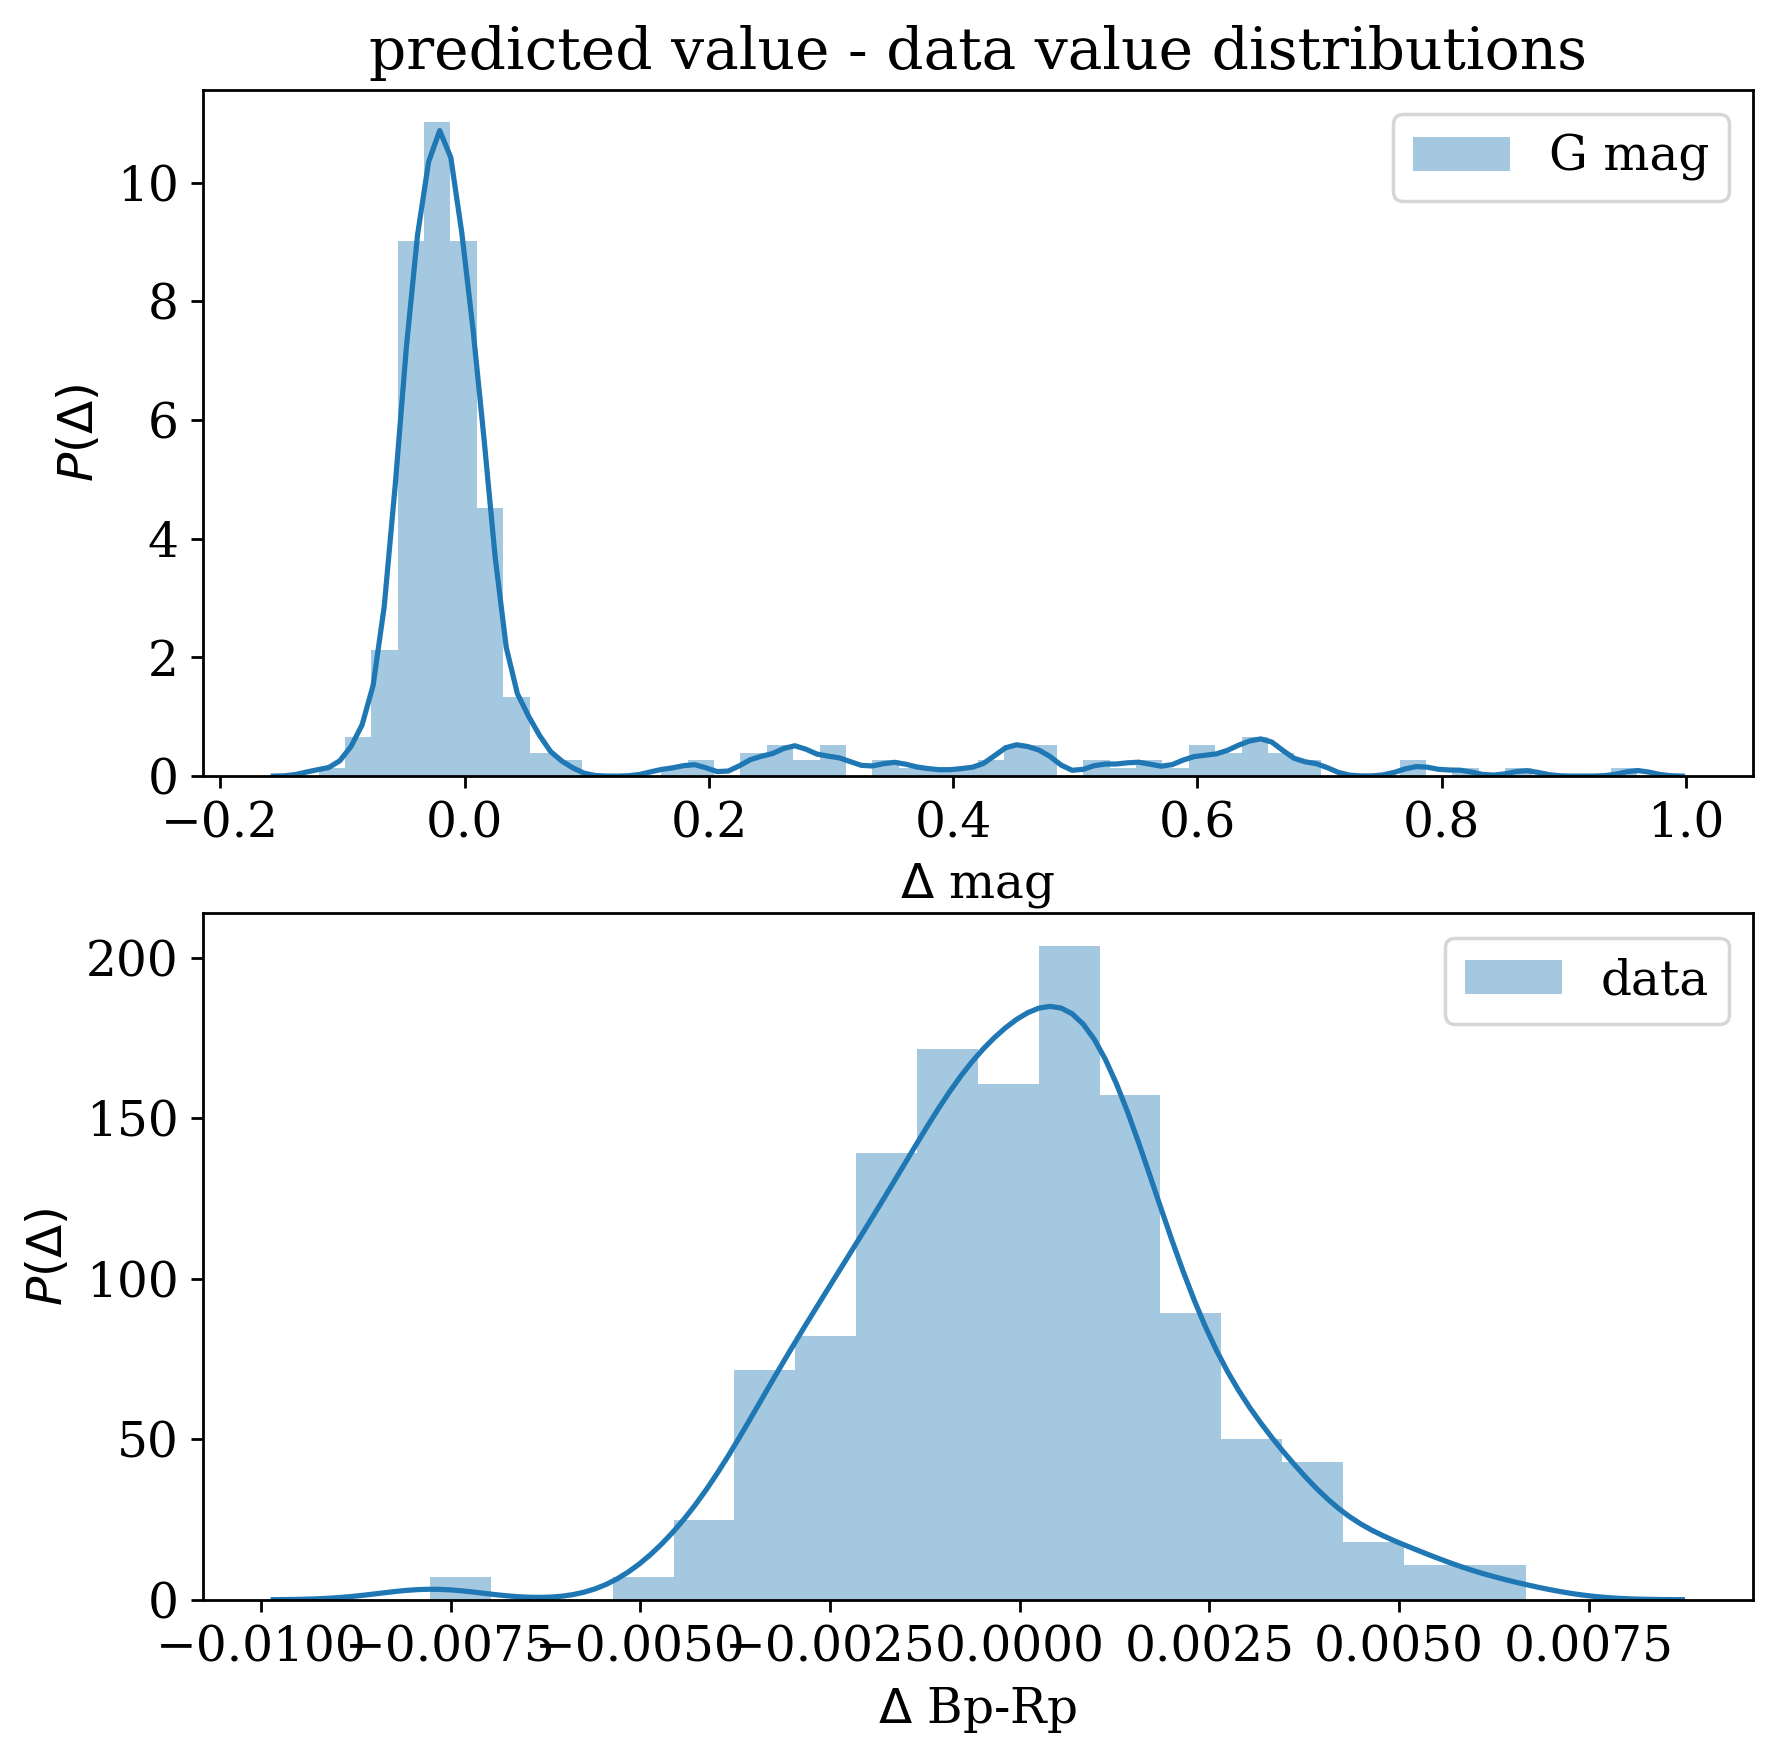

In [13]:
draw = 0
fig, [ax,bx] = plt.subplots(2,1,figsize=[8,8],dpi=250)
sns.distplot(trace['true_mG'][draw, :] - M67.g_mag.values, label='G mag', ax=ax)
#sns.distplot(trace['true_Bp'][draw, :] - M67.bp_mag.values, label='Bp mag', ax=ax)
#sns.distplot(trace['true_Rp'][draw, :] - M67.rp_mag.values, label='Rp mag', ax=ax)
ax.set_xlabel('$\Delta$ mag')
ax.set_ylabel('$P(\Delta)$')
ax.set_title('predicted value - data value distributions')
ax.legend()

sns.distplot((trace['true_Bp_Rp'][draw, :]) - M67.Bp_Rp.values, label='data', ax=bx)
bx.set_xlabel('$\Delta$ Bp-Rp')
bx.set_ylabel('$P(\Delta)$')
bx.legend()
plt.show()

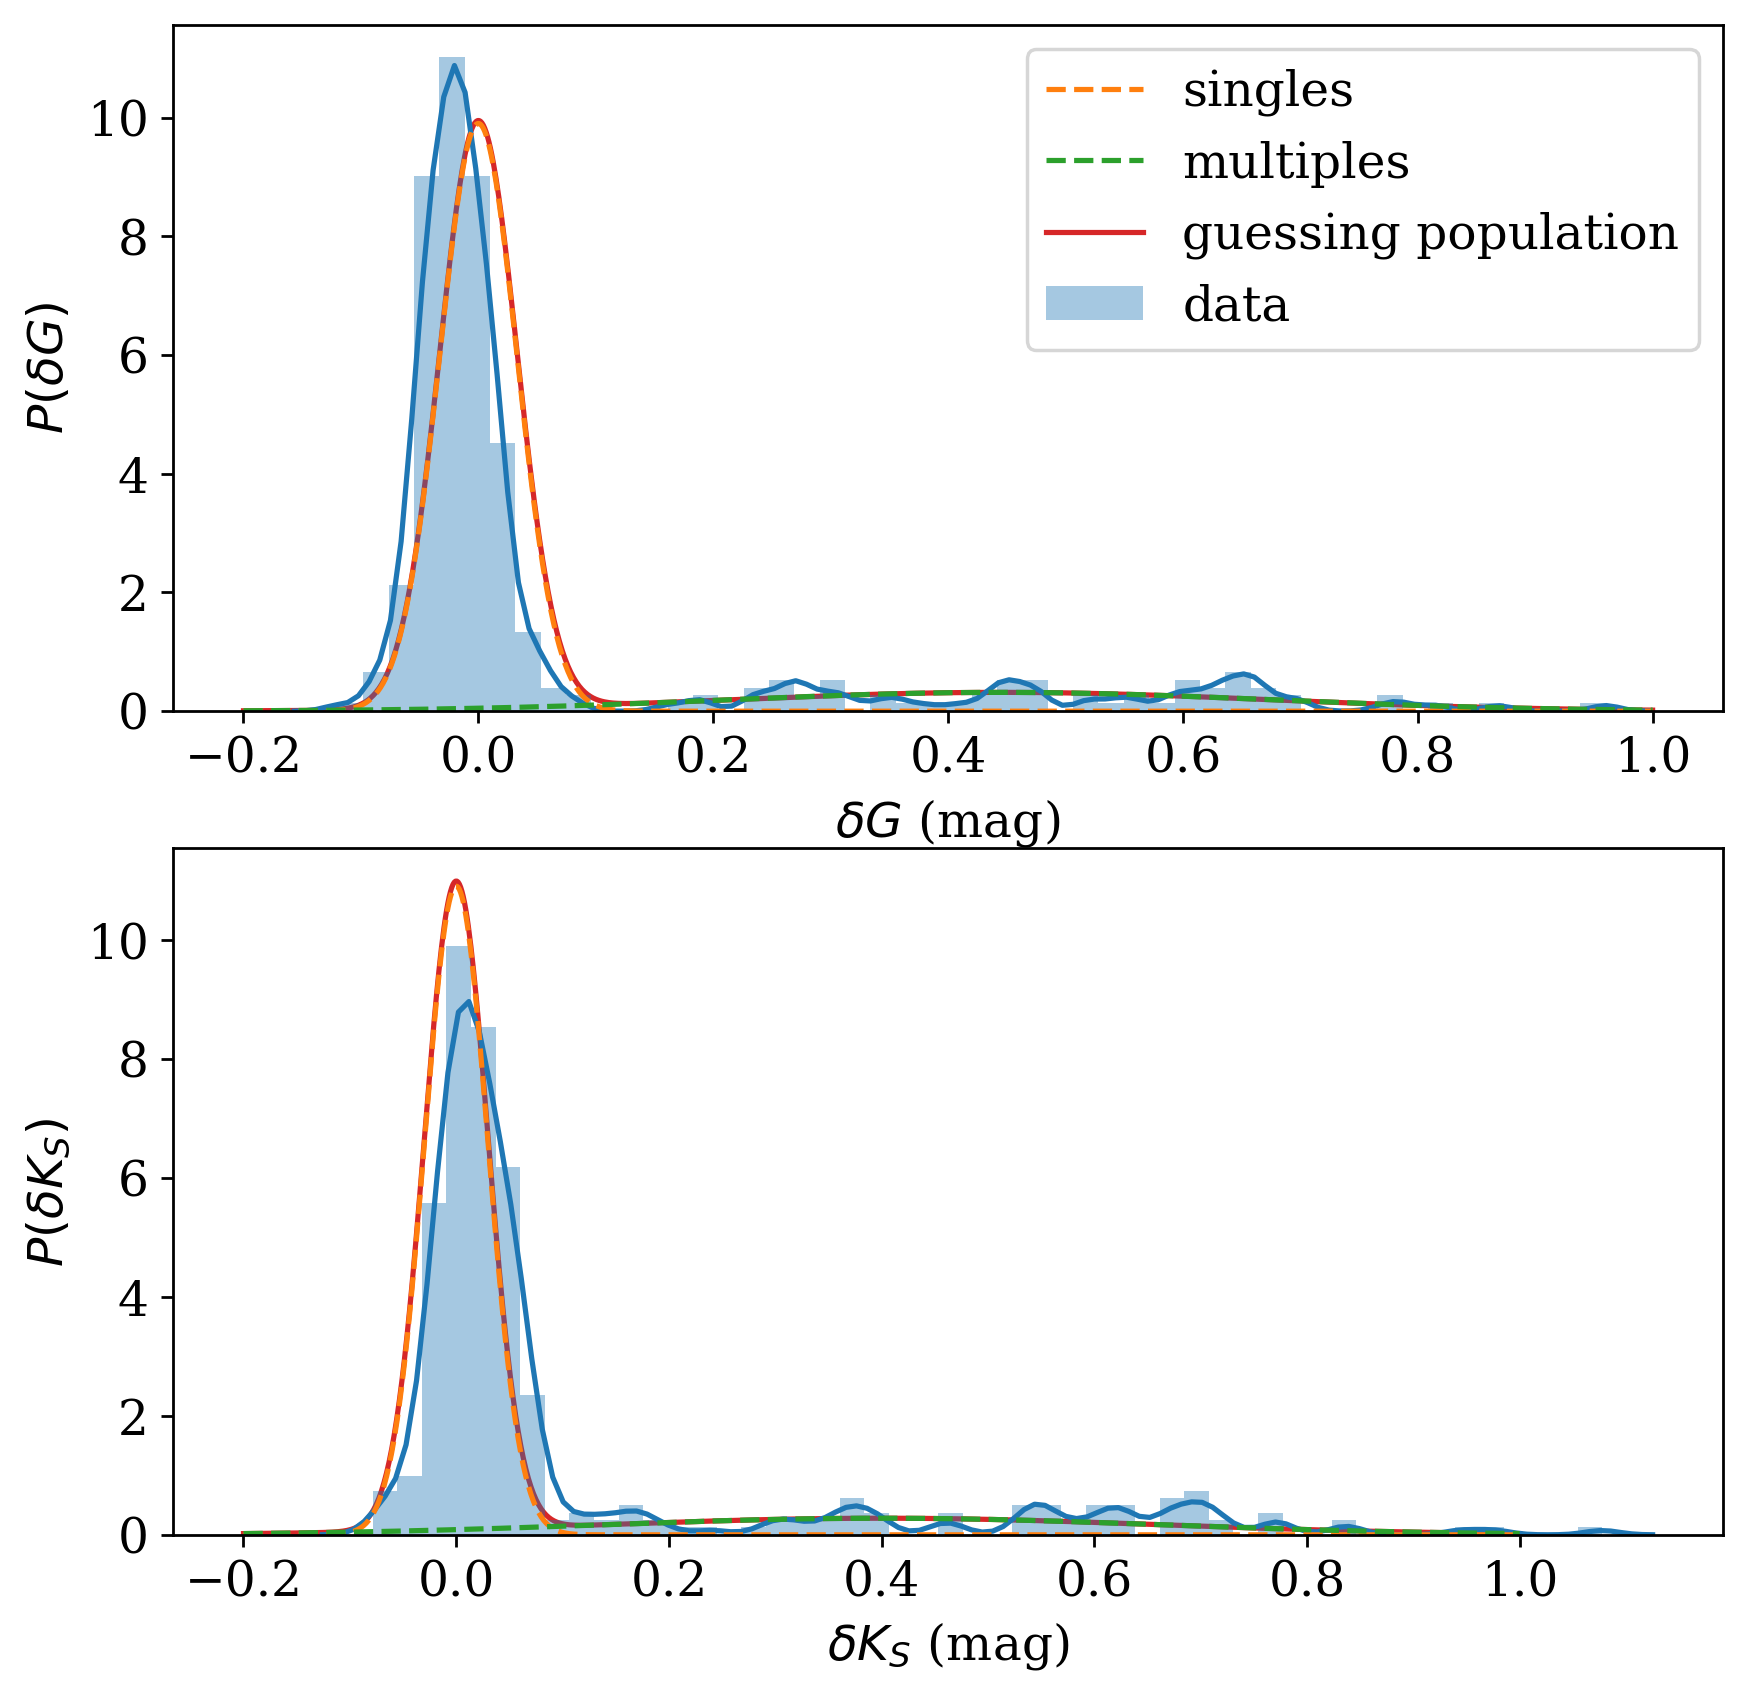

In [14]:
draw = 0
fig, ax = plt.subplots(2,1, figsize=[8,8],dpi=250)
sns.distplot(trace['true_mG'][draw, :] - M67.g_mag.values, label='data', ax=ax[0])

ind = np.linspace(-0.2, 1.0, 1000)
mean_g_mag_err = [np.mean(M67['g_mag_err'])*100, trace['sigma_multiple_G'][draw]]
q_values = [trace['q'][draw],1-trace['q'][draw]]
single = q_values[0] / np.sqrt(2 * np.pi) / mean_g_mag_err[0] * \
        np.exp(-0.5 * (ind)**2 / mean_g_mag_err[0]**2)
double = q_values[1] / np.sqrt(2 * np.pi) / mean_g_mag_err[1] * \
        np.exp(-0.5 * (ind-trace['delta_mG'][draw])**2 / mean_g_mag_err[1]**2)
ax[0].plot(ind, single, linestyle='--', label='singles')
ax[0].plot(ind, double, linestyle='--', label='multiples')
ax[0].plot(ind, single + double, label='guessing population',zorder=-1)
ax[0].set_xlabel('$\delta G$ (mag)')
ax[0].set_ylabel('$P(\delta G)$')
ax[0].legend()

sns.distplot(trace['true_mK'][draw, :] - M67.K_mag.values, label='data', ax=ax[1])
ind = np.linspace(-0.2, 1.0, 1000)
mean_k_mag_err = [np.mean(M67['K_mag_err']), trace['sigma_multiple_K'][draw]]
single = q_values[0] / np.sqrt(2 * np.pi) / mean_k_mag_err[0] * \
        np.exp(-0.5 * (ind)**2 / mean_k_mag_err[0]**2)
double = q_values[1] / np.sqrt(2 * np.pi) / mean_k_mag_err[1] * \
        np.exp(-0.5 * (ind-trace['delta_mK'][draw])**2 / mean_k_mag_err[1]**2)
ax[1].plot(ind, single, linestyle='--', label='singles')
ax[1].plot(ind, double, linestyle='--', label='multiples')
ax[1].plot(ind, single + double, label='guessing population',zorder=-1)
ax[1].set_xlabel('$\delta K_S$ (mag)')
ax[1].set_ylabel('$P(\delta K_S)$')
plt.savefig(trace_file+'/mixture_model_dist.png')
plt.show()

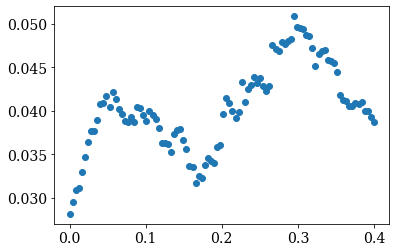

In [110]:
#testing optimization on the gap between K and G band data-true distribution peak value

TN = 1000
Tmass = np.linspace(0.8,1.20,TN)
Tage = np.ones(TN)*2.198
Tfeh = np.ones(TN)*0.1
TY = np.ones(TN)*0.248
TMLT = 0.976*(Tmass-1.0)+1.81
#Av = 0.181
#TAv = np.ones(TN)*Av
dist_mod = 9.729

def calGKgap(x):
    #Tfeh = np.ones(TN)*x[0]
    TAv = np.ones(TN)*x
    TmG, TmK, TBp_Rp = gen_cluster(Tmass, Tage, Tfeh, TY, TMLT, TAv, dist_mod)
    diffG = interpolate(TBp_Rp, TmG, M67['Bp_Rp']) - M67['g_mag']
    diffK = interpolate(TBp_Rp, TmK, M67['Bp_Rp']) - M67['K_mag']
    return abs(np.median(diffG[diffG<0.2])-np.median(diffK[diffK<0.2]))

gap = []
x = np.linspace(0,0.4,100)
for i in x:
    gap.append(calGKgap(i))
    
plt.scatter(x,gap)

x0 = 0.2
print(optimize.minimize(calGKgap, x0, bounds=[(0.0,0.4)]))

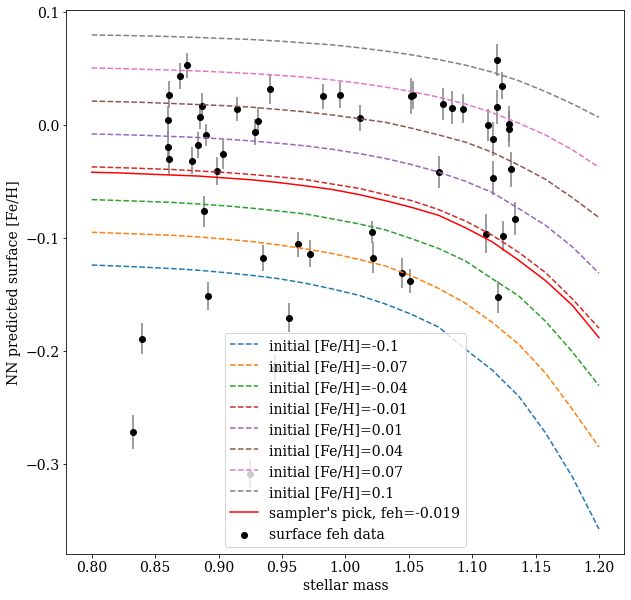

In [40]:
draw=np.random.randint(1000)
feh_range = np.linspace(-0.1,0.10,8)
fig, ax = plt.subplots(1,1,figsize=[10,10])
for f in feh_range:
    Tmass = np.linspace(0.8,1.2,20)
    Tage = np.ones(20)*trace['mean_age'][draw]
    Tfeh = np.ones(20)*f
    TY = np.ones(20)*trace['mean_Y'][draw]
    #TMLT = np.ones(20)*trace['mean_MLT'][draw]
    TMLT = trace['MLT_f'][draw]*(Tmass-1.0)+trace['mean_MLT'][draw]+np.random.randn(20)*trace['spread_MLT'][draw]
    
    obs = m1.predict([Tmass,Tage,Tfeh,TY,TMLT])
    
    ax.plot(Tmass, obs[3],'--', label='initial [Fe/H]='+str(np.round(f,2)))
    
Tmass = np.linspace(0.8,1.2,20)
Tage = np.ones(20)*trace['mean_age'][draw]
Tfeh = np.ones(20)*trace['mean_feh'][draw]
TY = np.ones(20)*trace['mean_Y'][draw]
#TMLT = np.ones(20)*trace['mean_MLT'][draw]
TMLT = trace['MLT_f'][draw]*(Tmass-1.0)+trace['mean_MLT'][draw]+np.random.randn(20)*trace['spread_MLT'][draw]

obs = m1.predict([Tmass,Tage,Tfeh,TY,TMLT])

ax.plot(Tmass, obs[3],'r-', label="sampler's pick, feh="+str(np.round(trace['mean_feh'][draw],3)))

lims = [ax.get_xlim(), ax.get_ylim()]
surface_feh_data_index = M67.dropna(subset=['APOGEE_feh']).index
ax.scatter(trace['mass'][draw,:][surface_feh_data_index], M67['APOGEE_feh'][surface_feh_data_index], color='k', label='surface feh data')
ax.errorbar(trace['mass'][draw,:][surface_feh_data_index], M67['APOGEE_feh'][surface_feh_data_index], 
            yerr=M67['APOGEE_feh_err'][surface_feh_data_index], color='gray', alpha=1.0, fmt='.', zorder=-1)
#ax.scatter(trace['mass'][draw,:], M67['[Fe/H]'], color='gray', alpha=0.2, zorder=-2, label='injected data for the other stars')
#ax.scatter(trace['mass'][draw,:], trace['true_s_feh'][draw,:], color='blue', s=15, zorder=1, label='HBM prediction')
ax.legend()
ax.set_xlabel('stellar mass')
ax.set_ylabel('NN predicted surface [Fe/H]')
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
plt.show()

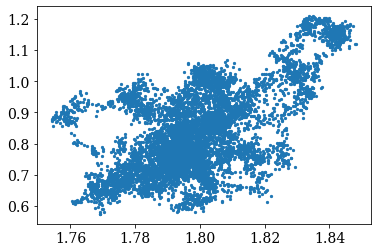

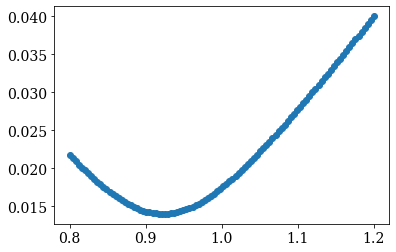

[0.92121212] [1.7332585]


In [17]:
plt.scatter(trace['mean_MLT'],trace['MLT_f'],s=5)
plt.show()
#draws = np.random.randint(len(trace['mean_MLT']),size=100)
#x = np.linspace(0.8,1.2,5)
#for i in draws:
#    plt.plot(x, trace['mean_MLT'][i]+trace['MLT_f'][i]*(x-1.0))
#plt.show()
x = np.linspace(0.8,1.2,100)
means = []
stds = []
for xi in x:
    MLTs = trace['mean_MLT']+trace['MLT_f']*(xi-1.0)
    means.append(np.mean(MLTs))
    stds.append(np.std(MLTs))
plt.scatter(x,stds)
plt.show()
print(x[stds==min(stds)],np.array(means)[stds==min(stds)])

In [20]:
lines = open('data_collection/NGC_2682/DSouto_spectra_surfaceFeH_table.txt','r').read().split('\n')
data = []
for line in lines:
    elements = line.split('\t')[:-1]
    data.append(elements)
data = pd.DataFrame(data[1:],columns=data[0])
data.to_csv('data_collection/NGC_2682/DSouto_spectra_surfaceFeH_table.csv', index=False)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (4, 0), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (4, 1), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (4, 2), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (4, 3), minimum_shape: (chains=2, draws=4)


1.5692035072392152


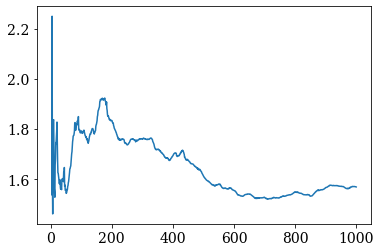

In [7]:
Rhats= []
for i in range(1000):
    Rhats.append(pm.rhat(np.array(trace.get_values('zero_pt', burn=0, combine=False))[:,:i]))
plt.plot(range(1000),Rhats)
print(Rhats[-1])

C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\plot_utils.py:557: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222C5A00280>,
      dtype=object)

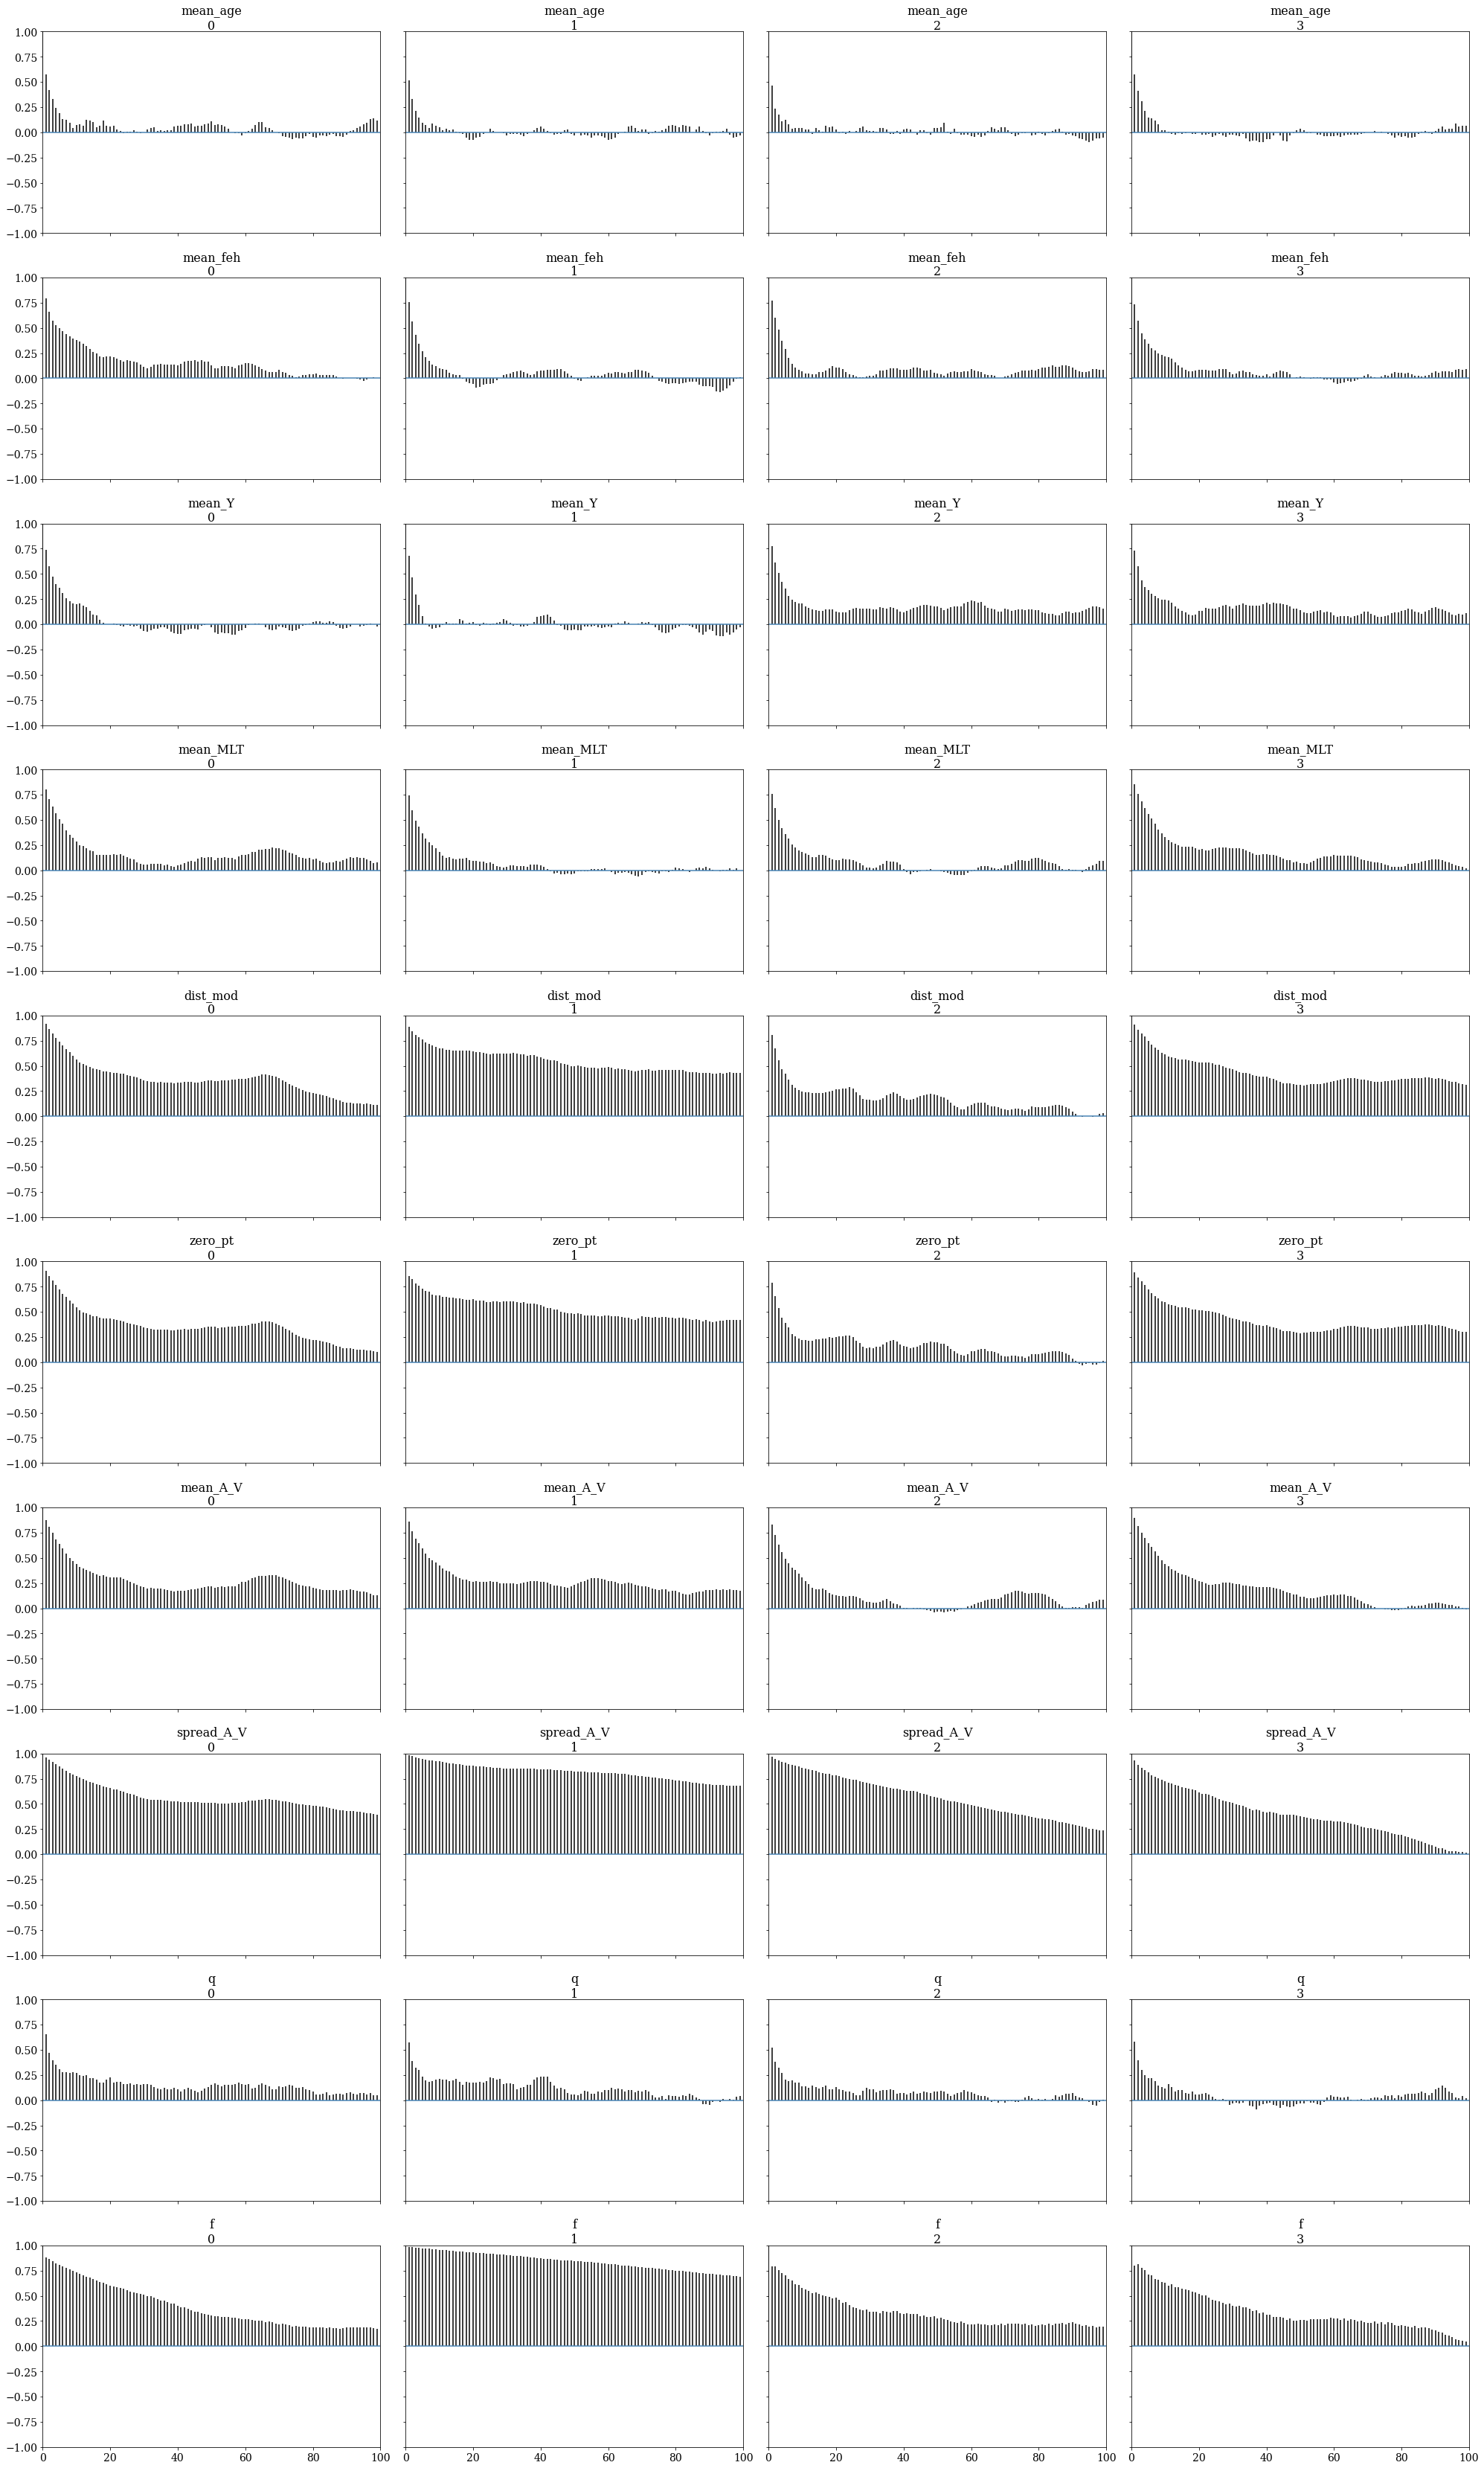

In [24]:
pm.autocorrplot(trace, var_names=['mean_age','mean_feh','mean_Y','mean_MLT',#'MLT_f',#'spread_MLT',
                                       'dist_mod','zero_pt','mean_A_V','spread_A_V','q','f','delta_mG','sigma_multiple'])

C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000222C8087DF0>,
      dtype=object)

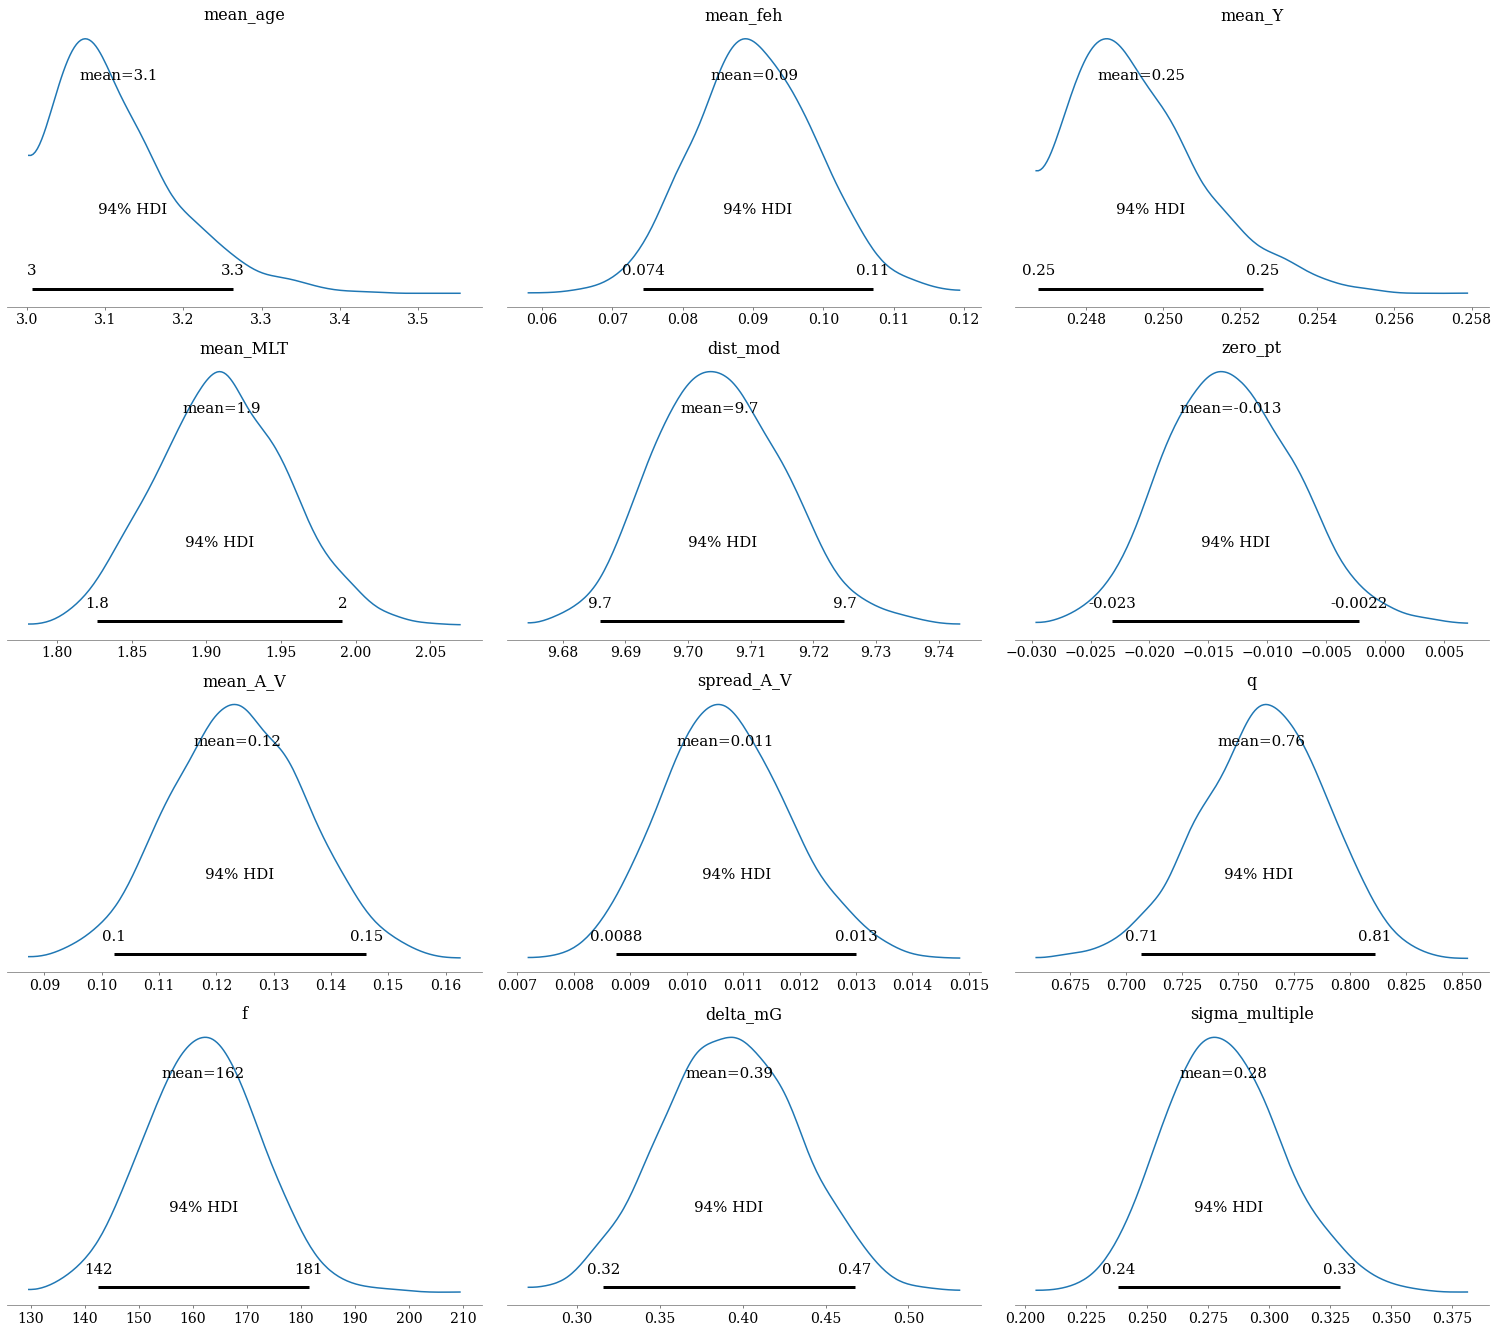

In [12]:
pm.plot_posterior(trace, var_names=['mean_age','mean_feh','mean_Y','mean_MLT',#'MLT_f',#'spread_MLT',
                                       'dist_mod','zero_pt','mean_A_V','spread_A_V','q','f','delta_mG','sigma_multiple'])

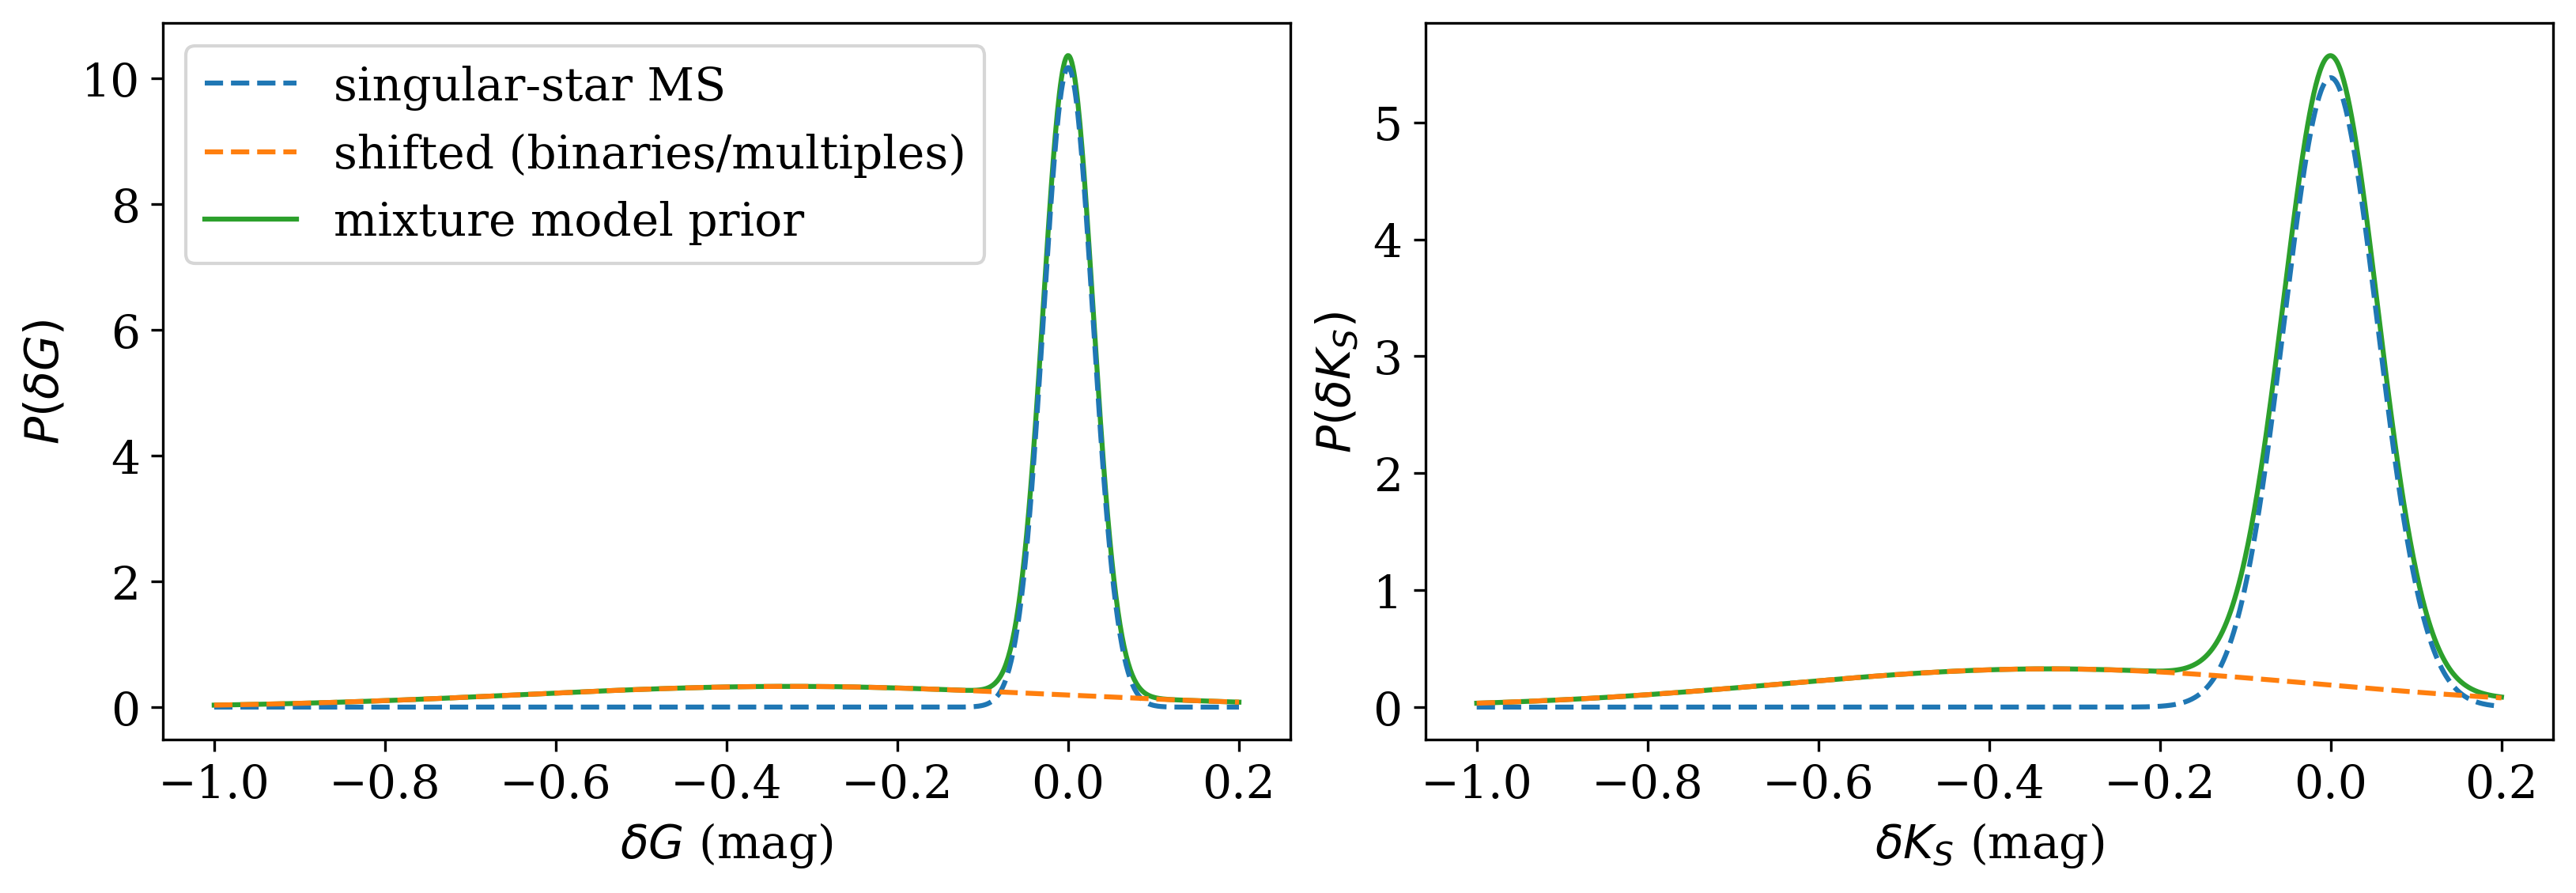

In [103]:
def gd(trace_variable, draw):
    if draw is None:
        return np.mean(trace_variable)
    else:
        return trace_variable[draw]

def plotMixture(trace, draw):
    fig, ax = plt.subplots(1,2, figsize=[13,4],dpi=300)
    
    TN = 100
    Tmass = np.linspace(0.8,1.20,TN)
    Tage = np.ones(TN)*4.0
    Tfeh = np.ones(TN)*0.10
    TY = np.ones(TN)*0.26
    TMLT = 1.0*(Tmass-1.0)+2.0
    Av = 0.11
    TAv = np.ones(TN)*Av
    dist_mod = 9.72

    #TmG, TmK, TBp_Rp = gen_cluster(Tmass, Tage, Tfeh, TY, TMLT, TAv, dist_mod)
    #predicted_mG = interpolate(TBp_Rp, TmG, M67['Bp_Rp'])
    #sns.distplot(M67['g_mag']-predicted_mG, ax=ax)

    ind = np.linspace(-1.0, 0.2, 1000)
    mean_g_mag_err = [np.mean(M67['g_mag_err'])*gd(trace['f_G'],draw), gd(trace['sigma_multiple_G'],draw)]
    #mean_g_mag_err = [trace['sigma_single_G'][draw], trace['sigma_multiple_G'][draw]]
    q_values = [gd(trace['q'],draw)/2+0.5,1-(gd(trace['q'],draw)/2+0.5)]
    single = q_values[0] / np.sqrt(2 * np.pi) / mean_g_mag_err[0] * \
            np.exp(-0.5 * (ind)**2 / mean_g_mag_err[0]**2)
    double = q_values[1] / np.sqrt(2 * np.pi) / mean_g_mag_err[1] * \
            np.exp(-0.5 * (ind+gd(trace['delta_mG'],draw))**2 / mean_g_mag_err[1]**2)
    ax[0].plot(ind, single, linestyle='--', label='singular-star MS')
    ax[0].plot(ind, double, linestyle='--', label='shifted (binaries/multiples)')
    ax[0].plot(ind, single + double, label='mixture model prior',zorder=-1)
    ax[0].set_xlabel('$\delta G$ (mag)')
    ax[0].set_ylabel('$P(\delta G)$')
    #ax[0].set_xlim(-1.0,0.2)
    #ax[0].set_ylim(0,ax[0].get_ylim()[1])
    ax[0].legend()
    
    ind = np.linspace(-1.0, 0.2, 1000)
    mean_g_mag_err = [np.mean(M67['K_mag_err'])*gd(trace['f_K'],draw), gd(trace['sigma_multiple_K'],draw)]
    #mean_g_mag_err = [trace['sigma_single_G'][draw], trace['sigma_multiple_G'][draw]]
    q_values = [gd(trace['q'],draw)/2+0.5,1-(gd(trace['q'],draw)/2+0.5)]
    single = q_values[0] / np.sqrt(2 * np.pi) / mean_g_mag_err[0] * \
            np.exp(-0.5 * (ind)**2 / mean_g_mag_err[0]**2)
    double = q_values[1] / np.sqrt(2 * np.pi) / mean_g_mag_err[1] * \
            np.exp(-0.5 * (ind+gd(trace['delta_mK'],draw))**2 / mean_g_mag_err[1]**2)
    ax[1].plot(ind, single, linestyle='--', label='singular-star MS')
    ax[1].plot(ind, double, linestyle='--', label='shifted (binaries/multiples)')
    ax[1].plot(ind, single + double, label='mixture model prior',zorder=-1)
    ax[1].set_xlabel('$\delta K_S$ (mag)')
    ax[1].set_ylabel('$P(\delta K_S)$')
    #ax[1].set_xlim(-1.0,0.2)
    #ax[1].set_ylim(0,ax[1].get_ylim()[1])
    
    plt.subplots_adjust(wspace=0.12)
    plt.show()
    
plotMixture(trace2, None)